This notebook will be used for immune cell clutering to see if there are differences between clusters that can be observed and are of importance. I will first do the clustering and PCA on normalized gene expression data and then I will find genes of importance by ordering in terms of variance of the normalized terms. I will look at teh BAP1 subgroups and look at the most variance genes and perform MW tests on the two groups to see if they are statistically different enough.


## Imports

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import TumorDecon as td
from scipy.stats import wilcoxon
import seaborn as sns
from itertools import combinations
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree._tree import TREE_LEAF
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
import seaborn as sns
from scipy import stats
from sklearn.tree import _tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.tree._tree import TREE_LEAF
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
import seaborn as sns
from scipy import stats
from sklearn.tree import _tree
from itertools import combinations
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans
from collections import Counter
from itertools import combinations 
from statsmodels.stats.proportion import proportions_ztest
from sklearn.tree import DecisionTreeClassifier

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## Data Organizing

In [2]:
gene_expression = pd.read_excel('C:/Users/NathanGrant/Programs/TripodsREU/data/uvm_tcga_pan_can_atlas_2018/data_RNA_Seq_v2_expression_median_excel.xlsx',index_col="Hugo_Symbol")
gene_expression = td.df_normalization(gene_expression, "minmax").T
gene_expression.head()

Hugo_Symbol,UBE2Q2P2,RPL41P2,RPS6KA2,BRCA1,AI894139,ERICH5,SSX9P,CIITA,EZHIP,EFCAB8,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
TCGA-RZ-AB0B-01,0.000043,0.000812,0.008602,0.0,0.001557,0.000005,0.000005,0.0,0.000000,0.000000,...,0.002176,0.003192,0.000492,0.002008,0.004517,0.000005,0.005264,0.025455,0.017564,0.006148
TCGA-V3-A9ZX-01,0.000011,0.000476,0.004530,0.0,0.000534,0.000000,0.000000,0.0,0.000000,0.000003,...,0.001074,0.002585,0.000131,0.000925,0.002502,0.000000,0.004564,0.010680,0.009420,0.004747
TCGA-V3-A9ZY-01,0.000002,0.000063,0.001387,0.0,0.000202,0.000000,0.000000,0.0,0.000003,0.000000,...,0.000299,0.000516,0.000071,0.000321,0.001789,0.000008,0.000563,0.009861,0.004064,0.000948
TCGA-V4-A9E5-01,0.000005,0.000037,0.001393,0.0,0.000059,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000082,0.000465,0.000051,0.000209,0.001203,0.000000,0.000486,0.013295,0.003746,0.000714
TCGA-V4-A9E7-01,0.000011,0.000132,0.003093,0.0,0.000224,0.000001,0.000000,0.0,0.000000,0.000001,...,0.000466,0.000963,0.000064,0.000434,0.000906,0.000000,0.000569,0.008048,0.004292,0.000843


In [162]:
weird_gene_expression = pd.read_excel('C:/Users/NathanGrant/Programs/TripodsREU/data/uvm_tcga_pan_can_atlas_2018/data_RNA_Seq_v2_expression_median_excel.xlsx',index_col="Hugo_Symbol").T
weird_gene_expression.head()

Hugo_Symbol,UBE2Q2P2,RPL41P2,RPS6KA2,BRCA1,AI894139,ERICH5,SSX9P,CIITA,EZHIP,EFCAB8,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
TCGA-RZ-AB0B-01,4.8264,91.0674,964.760,0.0,174.6680,0.5107,0.5107,0.0,0.0000,0.0000,...,244.0550,358.018,55.1583,225.230,506.639,0.5107,590.398,2854.95,1969.87,689.479
TCGA-V3-A9ZX-01,2.1699,91.2986,869.041,0.0,102.4660,0.0000,0.0000,0.0,0.0000,0.5479,...,205.9400,495.890,25.2055,177.534,480.000,0.0000,875.616,2048.77,1807.12,910.685
TCGA-V3-A9ZY-01,0.7299,29.1022,640.146,0.0,93.4307,0.0000,0.0000,0.0,1.4599,0.0000,...,137.8470,237.956,32.8467,148.175,825.547,3.6496,259.854,4550.36,1875.18,437.226
TCGA-V4-A9E5-01,2.6070,20.6022,780.507,0.0,33.2805,0.0000,0.0000,0.0,0.0000,0.0000,...,45.8954,260.697,28.5261,117.274,674.327,0.0000,272.583,7449.29,2099.05,400.159
TCGA-V4-A9E7-01,4.7598,55.0171,1287.520,0.0,93.4107,0.5950,0.0000,0.0,0.0000,0.5950,...,194.0980,401.012,26.7738,180.872,377.213,0.0000,236.799,3350.29,1786.70,351.034


In [3]:
presence_df = pd.read_csv('C:/Users/NathanGrant/Programs/TripodsREU/data/uvm_tcga_pan_can_atlas_2018/data_CNA.txt',delimiter='\t', index_col="Hugo_Symbol")
presence_df= presence_df[presence_df.columns.difference(['Entrez_Gene_Id','Cytoband'])]
presence_df.head()

,TCGA-RZ-AB0B-01,TCGA-V3-A9ZX-01,TCGA-V3-A9ZY-01,TCGA-V4-A9E5-01,TCGA-V4-A9E7-01,TCGA-V4-A9E8-01,TCGA-V4-A9E9-01,TCGA-V4-A9EA-01,TCGA-V4-A9EC-01,TCGA-V4-A9ED-01,...,TCGA-WC-A885-01,TCGA-WC-A888-01,TCGA-WC-A88A-01,TCGA-WC-AA9A-01,TCGA-WC-AA9E-01,TCGA-YZ-A980-01,TCGA-YZ-A982-01,TCGA-YZ-A983-01,TCGA-YZ-A984-01,TCGA-YZ-A985-01
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
ACAP3,-1,0,0,0,-2,-1,0,0,0,0,...,0,0,0,-1,-1,0,-1,0,0,0
ACTRT2,-1,0,0,0,-2,-1,0,0,0,0,...,0,0,0,-1,-1,0,-1,0,0,0
AGRN,-1,0,0,0,-2,-1,0,0,0,0,...,0,0,0,-1,-1,0,-1,0,0,0
ANKRD65,-1,0,0,0,-2,-1,0,0,0,0,...,0,0,0,-1,-1,0,-1,0,0,0
ATAD3A,-1,0,0,0,-2,-1,0,0,0,0,...,0,0,0,-1,-1,0,-1,0,0,0


In [4]:
immune_fractions_df = td.combine_celltypes(pd.read_excel("C:/Users/NathanGrant/Programs/TripodsREU/data/CibersortResults/UVMRun1/CIBERSORTOutput_Job2.xlsx",index_col="Input Sample"))
immune_fractions_df= immune_fractions_df[immune_fractions_df.columns.difference(['RMSE','P-value','Pearson Correlation'])]
immune_fractions_df.head()

,B cells,CD4 T cells,CD8 T cells,DC,Eosinophils,Macrophages,Mast cells,Monocytes,NK cells,Neutrophils,Plasma cells,T cells gamma delta
Input Sample,,,,,,,,,,,,
TCGA-RZ-AB0B-01,0.000000,0.111888,0.000000,0.001386,0.0,0.078074,0.095050,0.000000,0.051481,0.0,0.015514,0.0
TCGA-V3-A9ZX-01,0.001096,0.037278,0.098547,0.004997,0.0,0.140180,0.078044,0.006261,0.009305,0.0,0.001147,0.0
TCGA-V3-A9ZY-01,0.040742,0.051491,0.043021,0.000000,0.0,0.190293,0.014546,0.011593,0.014273,0.0,0.029827,0.0
TCGA-V4-A9E5-01,0.005488,0.091727,0.000000,0.002013,0.0,0.187874,0.117979,0.000000,0.033693,0.0,0.001379,0.0
TCGA-V4-A9E7-01,0.019284,0.016001,0.034951,0.000000,0.0,0.195349,0.030027,0.005280,0.031016,0.0,0.083541,0.0


In [5]:
immune_fractions_df_uncombined = pd.read_excel("C:/Users/NathanGrant/Programs/TripodsREU/data/CibersortResults/UVMRun1/CIBERSORTOutput_Job2.xlsx",index_col="Input Sample")
immune_fractions_df_uncombined= immune_fractions_df_uncombined[immune_fractions_df_uncombined.columns.difference(['RMSE','P-value','Pearson Correlation'])]

In [6]:
phenotypes = pd.read_csv("../data/TCGA-UVM.GDC_phenotype.tsv",delimiter="\t",index_col="submitter_id.samples")
phenotypes.head()

,age_at_initial_pathologic_diagnosis,batch_number,bcr,bcr_followup_barcode,bcr_followup_uuid,submitter_id,clinical_M,clinical_N,clinical_T,clinical_stage,...,days_to_collection.samples,days_to_sample_procurement.samples,initial_weight.samples,is_ffpe.samples,oct_embedded.samples,preservation_method.samples,sample_type.samples,sample_type_id.samples,state.samples,tissue_type.samples
submitter_id.samples,,,,,,,,,,,,,,,,,,,,,
TCGA-V4-A9F7-01A,78,417.33.0,Nationwide Children's Hospital,TCGA-V4-A9F7-F66819,DE1CF63C-0469-4545-A095-BCA125977D94,TCGA-V4-A9F7,M0,N0,T3a,Stage IIB,...,747.0,NaN,50.0,False,False,NaN,Primary Tumor,1,released,Not Reported
TCGA-V4-A9E5-01A,51,417.33.0,Nationwide Children's Hospital,TCGA-V4-A9E5-F66658,C0DCBFC1-2F12-48AF-AF9C-498E1F89A1A4,TCGA-V4-A9E5,M0,N0,T4b,Stage IIIB,...,1923.0,NaN,80.0,False,False,NaN,Primary Tumor,1,released,Not Reported
TCGA-V4-A9EE-01A,86,417.33.0,Nationwide Children's Hospital,NaN,NaN,TCGA-V4-A9EE,M0,N0,T3a,Stage IIB,...,537.0,NaN,40.0,False,False,NaN,Primary Tumor,1,released,Not Reported
TCGA-YZ-A985-01A,41,417.33.0,Nationwide Children's Hospital,TCGA-YZ-A985-F66494,3ED3D1AA-1412-4225-B2BD-D1952057C31C,TCGA-YZ-A985,M0,N0,T4a,Stage IIIA,...,595.0,NaN,40.0,False,False,NaN,Primary Tumor,1,released,Not Reported
TCGA-VD-A8KF-01A,68,417.33.0,Nationwide Children's Hospital,NaN,NaN,TCGA-VD-A8KF,M0,N0,T4b,Stage IIIB,...,309.0,NaN,120.0,False,False,NaN,Primary Tumor,1,released,Not Reported


In [7]:
phenotypes_2 = pd.read_csv('C:/Users/NathanGrant/Programs/TripodsREU/data/uvm_tcga_pan_can_atlas_2018/data_clinical_patient.txt',delimiter="\t",index_col="PATIENT_ID")
phenotypes_2.head()

,SUBTYPE,CANCER_TYPE_ACRONYM,CENTER,IN_PANCANPATHWAYS_FREEZE,OS_STATUS,OS_MONTHS,DSS_STATUS,DSS_MONTHS,PFS_STATUS,PFS_MONTHS
PATIENT_ID,,,,,,,,,,
TCGA-V4-A9F8,UVM,UVM,Institut Curie,Yes,LIVING,19.627182,ALIVE OR DEAD TUMOR FREE,19.627182,CENSORED,19.627182
TCGA-V4-A9EQ,UVM,UVM,Institut Curie,Yes,DECEASED,14.958740,DEAD WITH TUMOR,14.958740,PROGRESSION,8.284841
TCGA-V4-A9EE,UVM,UVM,Institut Curie,Yes,DECEASED,13.084788,DEAD WITH TUMOR,13.084788,PROGRESSION,6.936910
TCGA-V3-A9ZY,UVM,UVM,Cleveland Clinic Foundation,Yes,LIVING,15.090246,ALIVE OR DEAD TUMOR FREE,15.090246,CENSORED,15.090246
TCGA-V4-A9EU,UVM,UVM,Institut Curie,Yes,LIVING,23.309334,ALIVE OR DEAD TUMOR FREE,23.309334,PROGRESSION,2.827366


In [8]:
patient_dict = {}
'''
Keys: Patient ID
    Attributes:
        BAP1_mutation
        Expression_Vector
        Immune_Fractions
        DSS_time
        Tumor_size
'''

'\nKeys: Patient ID\n    Attributes:\n        BAP1_mutation\n        Expression_Vector\n        Immune_Fractions\n        DSS_time\n        Tumor_size\n'

In [9]:
for patient_id in list(gene_expression.index):
    patient_dict[patient_id] = {}
    patient_dict[patient_id]['BAP1_mutation'] = presence_df.loc['BAP1', patient_id]
    patient_dict[patient_id]['expression_values'] = gene_expression.loc[patient_id].values
    patient_dict[patient_id]['immune_fractions'] = immune_fractions_df.loc[patient_id].values
    patient_dict[patient_id]['DSS_time'] = phenotypes_2.loc[patient_id[:-3],'DSS_MONTHS']
    if phenotypes_2.loc[patient_id[:-3],'OS_STATUS'] == 'LIVING':
        patient_dict[patient_id]['os_status'] = 1
    else:
        patient_dict[patient_id]['os_status'] = 0
    if patient_id+"A" in list(phenotypes.index):
        patient_dict[patient_id]['tumor_size'] = phenotypes.loc[patient_id+"A",'tumor_basal_diameter']
    else:
        patient_dict[patient_id]['tumor_size'] = np.nan
    if patient_id+"A" in list(phenotypes.index):
        patient_dict[patient_id]['weight'] = phenotypes.loc[patient_id+"A",'weight']
    else:
        patient_dict[patient_id]['weight'] = np.nan
    if patient_id+"A" in list(phenotypes.index):
        patient_dict[patient_id]['age'] = phenotypes.loc[patient_id+"A",'age_at_initial_pathologic_diagnosis']
    else:
        patient_dict[patient_id]['age'] = np.nan
    if patient_id+"A" in list(phenotypes.index):
        if np.isnan(phenotypes.loc[patient_id+"A","tumor_thickness"]):
            patient_dict[patient_id]["tumor_thickness"] = np.nan
        else:
            patient_dict[patient_id]["tumor_thickness"] = phenotypes.loc[patient_id+"A","tumor_thickness"]
    else:
        patient_dict[patient_id]["tumor_thickness"] = np.nan
    if patient_id+"A" in list(phenotypes.index):
        s = phenotypes.loc[patient_id+"A","tumor_stage.diagnoses"]
        if s == "stage iv":
            patient_dict[patient_id]['stage'] = 2
        elif s == 'stage iiib' or s == 'stage iiic' or s == "stage iiia":
            patient_dict[patient_id]['stage'] = 1
        elif s == 'stage iib' or s == "stage iia":
            patient_dict[patient_id]['stage'] = 0
        else:
            patient_dict[patient_id]['stage'] = np.nan
    else:
        patient_dict[patient_id]['stage'] = np.nan
    if patient_id+"A" in list(phenotypes.index):
        patient_dict[patient_id]['bmi'] = phenotypes.loc[patient_id+"A",'bmi.exposures']
    else:
        patient_dict[patient_id]['bmi'] = np.nan
    

In [10]:
Counter([phenotypes.loc[p+"A","tumor_stage.diagnoses"] for p in list(gene_expression.index) if p+"A" in list(phenotypes.index)])

Counter({'stage iv': 4,
         'stage iib': 26,
         'stage iiib': 10,
         'stage iiia': 24,
         'stage iiic': 1,
         'stage iia': 11,
         'not reported': 1})

## See if the PCA vectors correlate well with the top 10 most variant genes in the set

In [11]:
most_variant = td.variance_threshold_selector(gene_expression.T, threshold=0.01).T
most_variant= most_variant.T.assign(a=most_variant.var(axis=0)).sort_values('a').drop('a', axis=1).T
most_variant.shape

(80, 35)

In [12]:
pca = PCA(n_components=6)
pca_expression = pca.fit_transform(gene_expression.values)
print(sum(pca.explained_variance_ratio_))

0.800095010726134


In [13]:
len(pca_expression[0,:10]),len(most_variant.iloc[0,:6].values)

(6, 6)

In [14]:
np.mean([stats.pearsonr(pca_expression[i,:10],most_variant.iloc[i,:6].values)[0] for i in range(80)])

0.12916039123414547

If I am doing this correctly then the first 10 pca components and the top 10 most variant genes dont correlate very well with one another with almost 0 correlation.

## Perform Analysis Based off of Most Variant Genes
Instead of finding high entropy genes, find the most variant genes in each of the subgroups determined by K-means.

### Helper Functions

In [15]:
def SSE(points, labels, centers):
    total_error = 0
    data_mean = np.mean(points) 
    for i in range(len(points)):
        total_error += sum((points[i]-data_mean)**2)
    return total_error

def SSE_bet(points, labels, centers):
    total_error = 0
    data_mean = np.mean(points) 
    
    for k in range(len(centers)):
        n = sum([1 for l in labels if l == k])
        total_error += n*(sum((centers[k]-data_mean)**2))
    return total_error

def cluster_gene_variance(expression_df, pca_components=30, n_clusters=3,variance_threshold=.2):
    pca = PCA(n_components=pca_components)
    transormed_values = pca.fit_transform(expression_df.values)
    print("Tot Explained Var (PCA): ", sum(pca.explained_variance_ratio_))
    km= KMeans(n_clusters=n_clusters,n_init=5,random_state=42)
    labels = km.fit_predict(transormed_values)
    print("Frac Var Exp (k-menas): ",SSE_bet(transormed_values,labels,km.cluster_centers_)/SSE(transormed_values,labels,km.cluster_centers_))
    print(Counter(labels))
    group_dataframes = [pd.DataFrame(columns=expression_df.columns) for i in range(len(km.cluster_centers_))]
    
    for i in range(len(labels)):
        group_dataframes[labels[i]].loc[list(expression_df.index)[i]]=expression_df.iloc[i]
    
    for i in range(len(km.cluster_centers_)):
        group_dataframes[i]  = td.variance_threshold_selector(group_dataframes[i].T, threshold=variance_threshold).T
        group_dataframes[i].T.assign(a=group_dataframes[i].var(axis=0)).sort_values('a').drop('a', axis=1).T
    return group_dataframes

### Clustering 

In [16]:
group_dataframes = cluster_gene_variance(gene_expression,variance_threshold=.03,pca_components=6)

Tot Explained Var (PCA):  0.8000950107261324
Frac Var Exp (k-menas):  0.5521181039157241
Counter({0: 34, 1: 32, 2: 14})


In [17]:
group_dataframes[0].shape,group_dataframes[1].shape,group_dataframes[2].shape

((34, 3), (32, 7), (14, 13))

In [18]:
group_dataframes[0].columns[:10],group_dataframes[1].columns[:10],group_dataframes[2].columns[:10]

(Index(['EEF2', 'TYRP1', 'VIM'], dtype='object', name='Hugo_Symbol'),
 Index(['EEF1A1', 'GAPDH', 'RPL13', 'RPL8', 'RPS18', 'TYRP1', 'VIM'], dtype='object', name='Hugo_Symbol'),
 Index(['A2M', 'ADAM6', 'B2M', 'CD74', 'EEF1A1', 'HLA-A', 'HLA-B', 'HLA-C',
        'PABPC1', 'RPL8'],
       dtype='object', name='Hugo_Symbol'))

### Check differences between immune responses

There seems to be no overlap in between each of the 3 groups most variant genes. This is probably also because there is a very low correlation between the transformed PCA vectors and the most variant genes in general so therefore its not representing the genes variance but more of a mixture of a lot of variances. From here I will see if there are significant differences in immune response between these three groups. Then I will look at each of these groups top couple genes and see if there are major expression level differences between the groups. I will then check if these genes showed up in any of the pathways in the GSEA analysis.

In [19]:
grouped_ids = [list(group_dataframes[i].index) for i in range(len(group_dataframes))]

In [20]:
def cell_frequency_boxplot(sample_cell_freq, title,xsize=12, ysize=7):
    """
     Input:
        - 'sample_cell_freq': A dataframe that include cell frequency of samples
            Rows are samples id, columns are cell names
    Output:
        - cells frequency box plot in descending order
    """
    new_cell_freq = td.combine_celltypes(sample_cell_freq)
    b=new_cell_freq.median(axis = 0)
    b=list(zip(b.index,b))
    b = sorted(b, key=lambda x: x[-1],reverse=True)
    sorted_cells=[x[0] for x in b]
    new_cell_freq=new_cell_freq[sorted_cells]
    sns.set(rc={'figure.figsize':(xsize,ysize)})
    sns.set(style="white")
    palette={'Macrophages':'violet','CD8 T cells':'orange','CD4 T cells':'goldenrod','Monocytes':'lightsalmon','NK cells':'olivedrab','Mast cells':'red','B cells':'darkcyan','T cells gamma delta':'dodgerblue','DC':'gray','Plasma cells':'seagreen','Neutrophils':'navy', 'Eosinophils':'purple'}
    sns.boxplot(order=sorted_cells, data=new_cell_freq,palette=palette)
    sns.swarmplot(order=sorted_cells, data=new_cell_freq,color=".25")
    plt.xlabel('')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.ylabel('Frequencey')
    plt.subplots_adjust(top=0.95,bottom=0.2)
    plt.show()
    return plt

<span style="background-color: #FFFF00;font-size:24pt;text-align:center;">Plots of Immune Differences</span>

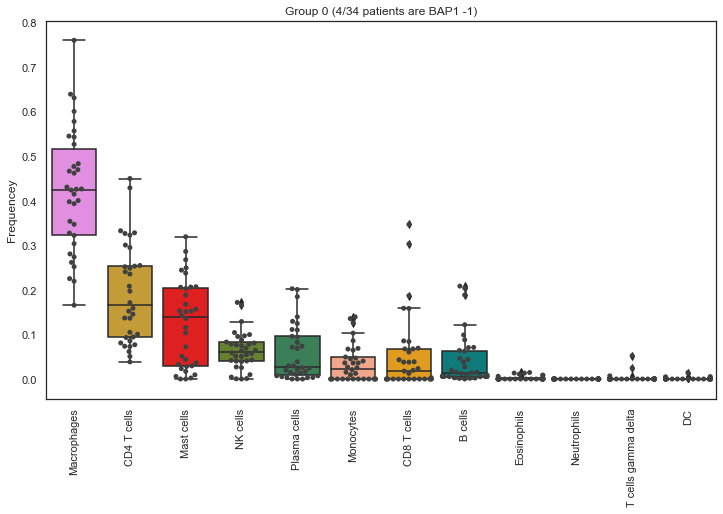

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [21]:
cell_frequency_boxplot(immune_fractions_df_uncombined.loc[grouped_ids[0]], "Group 0 (4/34 patients are BAP1 -1)")

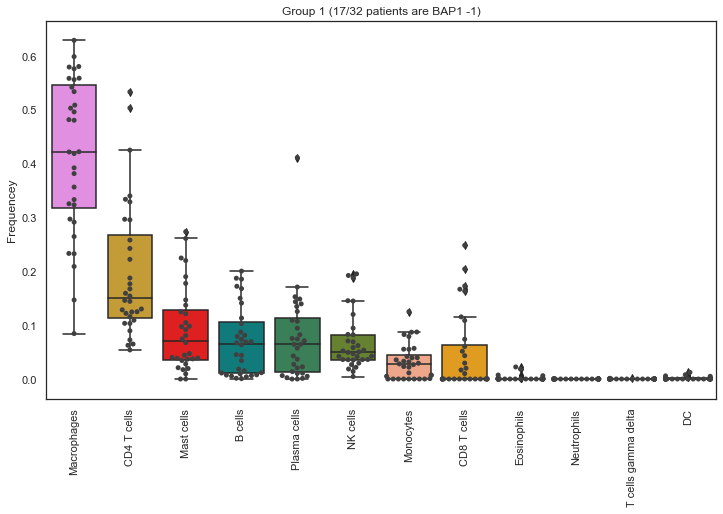

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [22]:
cell_frequency_boxplot(immune_fractions_df_uncombined.loc[grouped_ids[1]], "Group 1 (17/32 patients are BAP1 -1)")

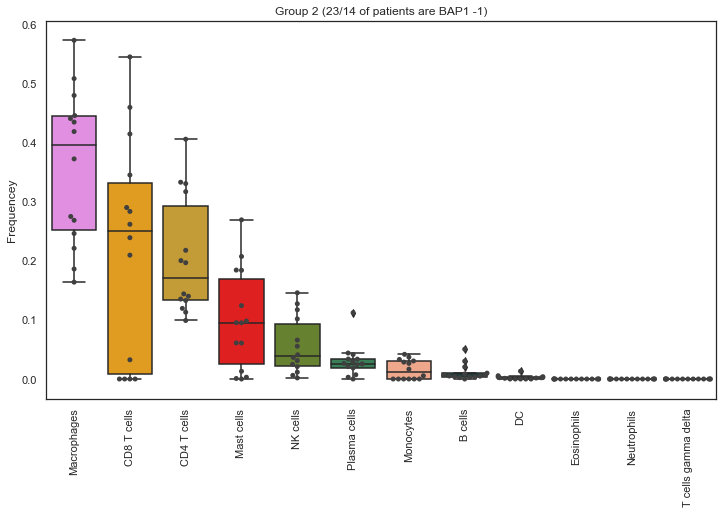

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [23]:
cell_frequency_boxplot(immune_fractions_df_uncombined.loc[grouped_ids[2]], "Group 2 (23/14 of patients are BAP1 -1)")

In [24]:
def print_significant_immune_differences(immune_fractions, grouped_ids):
    ## Test every immune cell against every group and print and return it if significant
    immune_cell_types = list(immune_fractions.columns)
    for i in range(len(immune_fractions.columns)):
        for c in combinations(list(range(len(grouped_ids))),2):
            if set(immune_fractions.loc[grouped_ids[c[0]],immune_cell_types[i]].values) != set(immune_fractions.loc[grouped_ids[c[1]],immune_cell_types[i]].values):
                mw_result = mannwhitneyu(immune_fractions.loc[grouped_ids[c[0]],immune_cell_types[i]].values,immune_fractions.loc[grouped_ids[c[1]],immune_cell_types[i]].values)
                if mw_result[1] < .05:
                    print(immune_cell_types[i]," difference between groups ",c[0]," ",c[1]," p-value: ", mw_result[1])

<span style="background-color: #FFFF00;font-size:24pt;text-align:center;">MW Tests of Immune Differences</span>

In [25]:
print_significant_immune_differences(immune_fractions_df,grouped_ids)

B cells  difference between groups  0   1  p-value:  0.028370012636226977
B cells  difference between groups  0   2  p-value:  0.022961201759575726
B cells  difference between groups  1   2  p-value:  0.00039808452072783964
CD8 T cells  difference between groups  0   2  p-value:  0.008456152480676354
CD8 T cells  difference between groups  1   2  p-value:  0.0021658582058942167
DC  difference between groups  0   2  p-value:  0.013138986481154283
DC  difference between groups  1   2  p-value:  0.023241497054659943
Eosinophils  difference between groups  0   2  p-value:  0.013188238425945183
Eosinophils  difference between groups  1   2  p-value:  0.022445547624537186
Plasma cells  difference between groups  1   2  p-value:  0.03572427424853873


Some interesting differences between these groups of these patients especially since they are some important cell types. 

- Group 2 seems to have a very different level of B cells than the other groups
- Group 0 seems to have a difference in the fraction of CD8 T Cells
- Group 2 seems to have a difference in the fraciton of DC Cells
- Other minor differences but both including group 2

### See where BAP1 -1 are distributes amongst these groups

In [26]:
print("Percentage of total BAP1 -1 by cluster: ",[sum([1 for p in grouped_ids[i] if patient_dict[p]['BAP1_mutation'] == -1])/44 for i in range(len(grouped_ids))])
print("Percentage of total BAP1 0 by cluster: ",[sum([1 for p in grouped_ids[i] if patient_dict[p]['BAP1_mutation'] == 0])/36 for i in range(len(grouped_ids))])
print("Percentage of BAP1 -1 by cluster: ",[sum([1 for p in grouped_ids[i] if patient_dict[p]['BAP1_mutation'] == -1])/len(grouped_ids[i]) for i in range(len(grouped_ids))])
print("Percentage of BAP1 0 by cluster: ",[sum([1 for p in grouped_ids[i] if patient_dict[p]['BAP1_mutation'] == 0])/len(grouped_ids[i]) for i in range(len(grouped_ids))])

Percentage of total BAP1 -1 by cluster:  [0.36363636363636365, 0.3181818181818182, 0.3181818181818182]
Percentage of total BAP1 0 by cluster:  [0.5, 0.5, 0.0]
Percentage of BAP1 -1 by cluster:  [0.47058823529411764, 0.4375, 1.0]
Percentage of BAP1 0 by cluster:  [0.5294117647058824, 0.5625, 0.0]


In [27]:
neg1_group = [[1 if patient_dict[p]['BAP1_mutation'] == -1 else 0 for p in grouped_ids[i] ] for i in range(len(grouped_ids))]
zero_group = [[1  if patient_dict[p]['BAP1_mutation'] == 0 else 0 for p in grouped_ids[i]] for i in range(len(grouped_ids))]
for c in combinations(list(range(len(grouped_ids))),2):
    print(c[0],c[1],proportions_ztest([sum(neg1_group[c[0]]),sum(neg1_group[c[1]])],[len(neg1_group[c[0]]),len(neg1_group[c[1]])])[1])

0 1 0.7873111605154324
0 2 0.0005738878701998282
1 2 0.00032206483430031275


Interestingly enough the clusters actually have a difference the amount of patients which carry the BAP1 -1 mutation. This is super interesting because these same groups also have differences in immune cell fractions. I will continue to check the differences in the fractions between the 0 group and the 2 group because there is a stark difference in the patients which have the mutation. 52% of all BAP1 -1 patients are in group 2 while only 9% belong to group 0. Maybe I should check the health outcomes of these patients between these two groups to see if there is anything crazy going on here. Groups 0 and 2 differ on many types of immune cells but I cannot just say that BAP1 -1 is to blame because group 1 has 38% of BAP1 -1 patients! So now I have to look a ways which only groups 0 and 2 are different which is just Monocytes. Now say that 1 and 2 could represent very simmilar groups and we just put them together for arguments sake. There would seem to be a stat significant difference between the aggregated group and group 0 for the fraction of CD8 T cells. A cell which is of importance. I will print out the stat significant results between the BAP1 -1 and BAP1 0 groups to see if there are also relavant differences. 

In [28]:
bap1_grouped_ids = [[],[]]
for p in list(patient_dict.keys()):
    if patient_dict[p]['BAP1_mutation'] == -1:
        bap1_grouped_ids[0].append(p)
    else:
        bap1_grouped_ids[1].append(p)
print_significant_immune_differences(immune_fractions_df,bap1_grouped_ids)

B cells  difference between groups  0   1  p-value:  0.0005880102093911836
DC  difference between groups  0   1  p-value:  0.04543268254395655
Monocytes  difference between groups  0   1  p-value:  0.003818424348530722


No difference in CD8 T cells, interesting... One difference that is also interesing is the fact that there is a large difference between the B cells in the BAP1 -1 group and the BAP1 0 group. This slso showed up in the clustering where group 2, which accounted for 52% of the BAP1 -1 patients and consisted of 100% BAP1 -1 patients also had a difference between the B cells in the other two clusters. There was also a difference in monocytes across the two groups, which again showed up in a test bewteen groups 0 and 2, with 20% and 100% of the clusters being BAP1 -1 respectivley.

In [29]:
for i in range(len(immune_fractions_df.columns)):
    x = []
    y = []
    for p in list(patient_dict.keys()):
        if not np.isnan(patient_dict[p]['os_status']):
            x.append(patient_dict[p]['immune_fractions'][i])
            y.append(gene_expression.loc[p,"BAP1"])
    x = np.asarray(x)
    r, p = stats.pearsonr(y,x)
    if p < .05:
        print("|","BAP1","|",immune_fractions_df.columns[i],"|",r,"|",p,"|")

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


## Test Health Outcomes

I am going to see if there are different health outcomes between the three groups. First I will start by seeing if there is any correlation between immune cell fractions and DSS months for all patients. Then I will test it for BAP1 -1 and BAP1 0 patients and finally between the three groups.

### Test All Patients

In [30]:
for i in range(len(immune_fractions_df.columns)):
    x = []
    y = []
    for p in list(patient_dict.keys()):
        if not np.isnan(patient_dict[p]['weight']):
            x.append(patient_dict[p]['immune_fractions'][i])
            y.append(patient_dict[p]['weight'])
    x = np.asarray(x)
    
    r, p = stats.pearsonr(x,y)
    if p < .05:
        print(immune_fractions_df.columns[i], " :", r, p)    

All patient observations:
- negative correlation between the CD8 T cells and the patients living status with a p value of 0.000192 and R of -0.4051 
- positive correlation between monocytes and the patients living status with p value 0.01163 and R 0.28079
- positive correlation between mast cells and disease survival time with p value .0595 and R of .21155
- negative correlation between B cells and tumor basal raduis with p value .00855 and R of -0.29962

### Test BAP1 -1 and BAP1 0 Patients

In [31]:
for opt in [0,-1]:
    print(opt, " Patients:")
    for i in range(len(immune_fractions_df.columns)):
        x = []
        y = []
        for p in list(patient_dict.keys()):
            if not np.isnan(patient_dict[p]['tumor_size']) and patient_dict[p]['BAP1_mutation'] == opt:
                x.append(patient_dict[p]['immune_fractions'][i])
                y.append(patient_dict[p]['age'])
        x = np.asarray(x)

        r, p = stats.pearsonr(x,y)
        if p < .05:
            print(immune_fractions_df.columns[i], " :", r, p)    

0  Patients:
-1  Patients:


0 Patients Observations:
- B cells still have a negative correlation with tumor radius with p value 0.0084935 and R -0.4442 which has an even greater magnitude
- CD4 T cells have positive correlation with tumor radius with p value .025175 and R 0.38346
- CD8 T cells have negative correlation with DSS time with p value of .02512 and R of -0.38358


-1 Patients Observations:
- No stat significant differences for immune cells on tumor size
- NK cells have positive correlation with DSS time with p value .0533 and R of .300218
- CD8 T cells have negative correlation with living status with p value 0.02063 and R of -0.3479
- Monocytes have positive correlation with living status with p value .03270 and R of .322596
- Mast Cells have positive correlation with living status with p value .05187 and R of .30205

Its interesting how the relationships are almost totally changed across these groups. For example across all of the patients the correlation between CD8 T cells and living status is negative with a very low p value. However in patients with BAP1 0 its almost nonexistent. The correlation between the two values still remains with BAP1 -1.

However its weird because there was a negative correlation with the BAP1 0  group between CD8 T cells and DSS time where there wasnt with BAP1 -1. Kinda conflicting information in a sense because one suggests that the CD8 T cells arent good for both sets of patients but their results from the tests are opposite.

### Test Cluster Groups

In [32]:
phenotypes = ["DSS_time","age","tumor_size","os_status","weight","bmi"]
for phen in phenotypes:
    #for opt in [0,1,2]:
   #     print(opt, " Patients:")
    for i in range(len(immune_fractions_df.columns)):
        x = []
        y = []
        for p in list(patient_dict.keys()):
            if not np.isnan(patient_dict[p][phen]) and p in grouped_ids[opt]:
                x.append(patient_dict[p]['immune_fractions'][i])
                y.append(patient_dict[p][phen])
        x = np.asarray(x)
        r, p = stats.pointbiserialr(x,y)
        if p < .05:
            print(immune_fractions_df.columns[i],'vs',phen , " :", r, p)

Monocytes vs DSS_time  : 0.5746247444471986 0.031604890162730624
B cells vs age  : 0.6926893984487386 0.0060315939239999556
Mast cells vs age  : -0.5439913681511293 0.04433040533869713


Group 0 Patients:
- No significant correlation between immune cells and DSS time
- Negative correlation between B cells and tumor radius with p value .007016 and R -0.61140
- No significant correlation between immune cells and living status
- Negative corralation between DC and weight p value .0349724 and R -0.5932

Group 1 Patients:
- Negative correlation between CD8 T cells and DSS time with pvalue .01516 and R -0.39632 
- Negative correlation between CD8 T cells and living status with pvalue .03705 and R -0.344067 
- Negative correlation between Plasma cells and weight p value 0.034972 and R -0.43210

Group 2 Patients:
- No significant correlation between immune cells and DSS time
- Positive correlation between B cells and tumor radius with p value .02782 and R .468591
- No significant correlation between immune cells and living status
- No significant correlation between immune cells and weight

<span style="background-color: #FFFF00">Interesting because the two most distinct groups in terms of BAP1 -1 and immune cell wise also have differences in tumor radius which dont come up in all patients. Actually this is really cool because the two groups actually have opposite reations to B cells and tumor radius.</span> It seems that in one group of patients the B cells might actually fight to reduce tumor size where as the other its harmful. 

### Correlation between BAP1 expression and immune cell fractions 

In [33]:
for i in range(len(immune_fractions_df.columns)):
    x = []
    y = []
    for p in list(patient_dict.keys()):
        if not np.isnan(patient_dict[p]['os_status']):
            x.append(patient_dict[p]['immune_fractions'][i])
            y.append(gene_expression.loc[p,"BAP1"])
    x = np.asarray(x)
    r, p = stats.pearsonr(y,x)
    if p < .05:
        print(immune_fractions_df.columns[i], " :", r, p)

Interestingly enough there is a correlation between the expression level of BAP1 and CD8 T cells which kinda confirms the previous findings and makes them more interesting. Also a positive correlation between monocytes and expresion. 

In [34]:
for opt in [0,1,2]:
    print(opt, " Patients:")
    for i in range(len(immune_fractions_df.columns)):
        x = []
        y = []
        for p in list(patient_dict.keys()):
            if not np.isnan(patient_dict[p]['os_status']) and p in grouped_ids[opt]:
                x.append(patient_dict[p]['immune_fractions'][i])
                y.append(gene_expression.loc[p,"BAP1"])
        x = np.asarray(x)
        r, p = stats.pearsonr(y,x)
        if p < .05:
            print(immune_fractions_df.columns[i], " :", r, p)        

0  Patients:
Macrophages  : -0.35565163065722954 0.03899344343536735
1  Patients:
2  Patients:
CD4 T cells  : 0.6393383224317281 0.01382300753547687


No correlations in the groups between immune fractions and BAP1 expression below .05. However group 1 patients have a negative correlation with CD8 Tcells p 0.06688 R -0.3045.

### Test Tumor Diameter Between Groups

In [35]:
for c in combinations([0,1,2],2):
    x1,x2 =[],[]
    for p in list(patient_dict.keys()):
        if p in grouped_ids[c[0]]:
            x1.append(patient_dict[p]['tumor_size'])
        elif p in grouped_ids[c[1]]:
            x2.append(patient_dict[p]['tumor_size'])
            #if not np.isnan(patient_dict[p]['os_status'])
    s,p = mannwhitneyu(x1,x2)
    print(c[0],c[1], p)

0 1 0.048037128162145316
0 2 0.4412291822496147
1 2 0.16044778648736469


No relationship between group and tumor diameter

In [36]:

x = []
y = []
for p in list(patient_dict.keys()):
    if not np.isnan(patient_dict[p]['tumor_size']):
        if patient_dict[p]['BAP1_mutation'] == -1:
            x.append(patient_dict[p]['tumor_size'])
        else:
            y.append(patient_dict[p]['tumor_size'])
x = np.asarray(x)

r, p = stats.mannwhitneyu(x,y)
#if p < .05:
print("Difference in tumor basal diameter between BAP1 0 and -1", " :", r, p)   

Difference in tumor basal diameter between BAP1 0 and -1  : 576.0 0.0750266736040705


Almost statistically significant difference between BAP1 mutation and tumor diameter.

## Find Highest correlated genes with immune fractions within and across groups
 Next I will test across all genes to see which genes have the highest corraltion with immune fractions inside each group.

### Correlation between groups high variance genes and immune fractions

In [37]:
for gene_name in list(group_dataframes[2].columns[:10]):
    for i in range(len(immune_fractions_df.columns)):
        x = []
        y = []
        for p in list(patient_dict.keys()):
            if not np.isnan(patient_dict[p]['os_status']):
                x.append(patient_dict[p]['immune_fractions'][i])
                y.append(gene_expression.loc[p,gene_name])
        x = np.asarray(x)
        r, p = stats.pearsonr(y,x)
        if p < .05:
            print("|",gene_name,"|",immune_fractions_df.columns[i],"|",r,"|",p,"|")

| A2M | B cells | -0.3007249198633977 | 0.0067185928917763 |
| A2M | CD8 T cells | 0.25240186411870635 | 0.02390047366603559 |
| A2M | Plasma cells | -0.29641572592633897 | 0.007590061282953663 |
| ADAM6 | CD8 T cells | 0.42088197376260034 | 0.00010130836095010227 |
| B2M | B cells | -0.2711152489442553 | 0.014994598200625256 |
| B2M | CD8 T cells | 0.7636685446700618 | 1.7595363841737923e-16 |
| B2M | Macrophages | -0.24373003130890403 | 0.029357895529049684 |
| CD74 | B cells | -0.23136695996792872 | 0.03892792495884268 |
| CD74 | CD8 T cells | 0.8343246468898015 | 7.202055535497824e-22 |
| CD74 | NK cells | -0.24325462078284735 | 0.029685244087065726 |
| EEF1A1 | Macrophages | -0.26652559703433876 | 0.016859448643500214 |
| HLA-A | B cells | -0.3086908523727017 | 0.005337170353167357 |
| HLA-A | CD8 T cells | 0.753016790430558 | 7.858320608045095e-16 |
| HLA-A | DC | 0.224648548328724 | 0.04513655833834426 |
| HLA-A | Macrophages | -0.23846747214130626 | 0.033156443920152226 |
| HLA

| Gene Name   | Cell Type | R Value        	| P-Value  	| Group High Variance |
|---------------|--|----	|----------	|---|
| A2M | B cells | -0.3007249198633977 | 0.0067185928917763 |
| A2M | CD8 T cells | 0.25240186411870635 | 0.02390047366603559 |
| A2M | Plasma cells | -0.29641572592633897 | 0.007590061282953663 |
| ADAM6 | CD8 T cells | 0.42088197376260034 | 0.00010130836095010227 |
| B2M | B cells | -0.2711152489442553 | 0.014994598200625256 |
| B2M | CD8 T cells | 0.7636685446700618 | 1.7595363841737923e-16 |
| B2M | Macrophages | -0.24373003130890403 | 0.029357895529049684 |
| CD74 | B cells | -0.23136695996792872 | 0.03892792495884268 |
| CD74 | CD8 T cells | 0.8343246468898015 | 7.202055535497824e-22 |
| CD74 | NK cells | -0.24325462078284735 | 0.029685244087065726 |
| EEF1A1 | Macrophages | -0.26652559703433876 | 0.016859448643500214 |
| HLA-A | B cells | -0.3086908523727017 | 0.005337170353167357 |
| HLA-A | CD8 T cells | 0.753016790430558 | 7.858320608045095e-16 |
| HLA-A | DC | 0.224648548328724 | 0.04513655833834426 |
| HLA-A | Macrophages | -0.23846747214130626 | 0.033156443920152226 |
| HLA-B | B cells | -0.25032282938125155 | 0.02512329492349371 |
| HLA-B | CD8 T cells | 0.8492504365267413 | 2.4446163560287699e-23 |
| HLA-B | Macrophages | -0.2600862727214175 | 0.019810311523371444 |
| HLA-B | NK cells | -0.2352010005179994 | 0.035715509873025235 |
| HLA-C | B cells | -0.28184271610468464 | 0.011316416955203952 |
| HLA-C | CD8 T cells | 0.8062713089499117 | 1.8207230508735992e-19 |
| HLA-C | Macrophages | -0.27586114554113766 | 0.01325636028038326 |
| PABPC1 | Monocytes | -0.23033845660318003 | 0.039829493690936295 |
| RPL8 | DC | 0.25937700907353956 | 0.020160870345642172 |

The APOL genes have a crazy high correlation with immune cell types of interest such as CD8 t cells and are of highest variance in group 2. Other than that the other high variance genes also have high positive correlations with CD8 T cells 

### Differences between groups high variance gene expressions

Here I am going to go over each of the most variant genes in each of the groups and see which ones show stat significantly differences in expression levels over groups. 

In [38]:
for gene_name in list(group_dataframes[2].columns[:10]):
    for c in combinations([0,1,2],2):
        x1,x2 =[],[]
        for p in list(patient_dict.keys()):
            if p in grouped_ids[c[0]]:
                x1.append(gene_expression.loc[p,gene_name])
            elif p in grouped_ids[c[1]]:
                x2.append(gene_expression.loc[p,gene_name])
                #if not np.isnan(patient_dict[p]['os_status'])
        s,p = mannwhitneyu(x1,x2)
        if p < .05:
            print("|",gene_name,"|",c[0],"|",c[1],"|", p,"|","2|")

| A2M | 0 | 1 | 0.010282421282433432 | 2|
| A2M | 0 | 2 | 4.603783626904068e-08 | 2|
| A2M | 1 | 2 | 1.5219559999836899e-07 | 2|
| ADAM6 | 0 | 2 | 0.006926727136222374 | 2|
| ADAM6 | 1 | 2 | 0.0051391678076250355 | 2|
| B2M | 0 | 1 | 0.006065080488190559 | 2|
| B2M | 0 | 2 | 1.391607523322966e-07 | 2|
| B2M | 1 | 2 | 2.5143230406103324e-07 | 2|
| CD74 | 0 | 2 | 9.001167765295426e-07 | 2|
| CD74 | 1 | 2 | 8.486212393950659e-07 | 2|
| EEF1A1 | 0 | 1 | 2.325522408598684e-09 | 2|
| EEF1A1 | 0 | 2 | 8.039779926375706e-07 | 2|
| HLA-A | 0 | 2 | 2.2395129683797836e-07 | 2|
| HLA-A | 1 | 2 | 2.5062133249452e-07 | 2|
| HLA-B | 0 | 1 | 0.027546724725201296 | 2|
| HLA-B | 0 | 2 | 3.593520305747394e-07 | 2|
| HLA-B | 1 | 2 | 6.677941716356656e-07 | 2|
| HLA-C | 0 | 1 | 0.009277048965972682 | 2|
| HLA-C | 0 | 2 | 2.5282986712644054e-07 | 2|
| HLA-C | 1 | 2 | 2.5143230406103324e-07 | 2|
| PABPC1 | 0 | 1 | 1.727443250553752e-09 | 2|
| PABPC1 | 0 | 2 | 6.686505767785259e-08 | 2|
| PABPC1 | 1 | 2 | 1.3

| Gene Name   | Group 1 | Group 2        	| P-Value  	| Group High Variance |
|---------------|--|----	|----------	|---|
| A2M | 0 | 1 | 0.010282421282433432 | 2|
| A2M | 0 | 2 | 4.603783626904068e-08 | 2|
| A2M | 1 | 2 | 1.5219559999836899e-07 | 2|
| ADAM6 | 0 | 2 | 0.006926727136222374 | 2|
| ADAM6 | 1 | 2 | 0.0051391678076250355 | 2|
| B2M | 0 | 1 | 0.006065080488190559 | 2|
| B2M | 0 | 2 | 1.391607523322966e-07 | 2|
| B2M | 1 | 2 | 2.5143230406103324e-07 | 2|
| CD74 | 0 | 2 | 9.001167765295426e-07 | 2|
| CD74 | 1 | 2 | 8.486212393950659e-07 | 2|
| EEF1A1 | 0 | 1 | 2.325522408598684e-09 | 2|
| EEF1A1 | 0 | 2 | 8.039779926375706e-07 | 2|
| HLA-A | 0 | 2 | 2.2395129683797836e-07 | 2|
| HLA-A | 1 | 2 | 2.5062133249452e-07 | 2|
| HLA-B | 0 | 1 | 0.027546724725201296 | 2|
| HLA-B | 0 | 2 | 3.593520305747394e-07 | 2|
| HLA-B | 1 | 2 | 6.677941716356656e-07 | 2|
| HLA-C | 0 | 1 | 0.009277048965972682 | 2|
| HLA-C | 0 | 2 | 2.5282986712644054e-07 | 2|
| HLA-C | 1 | 2 | 2.5143230406103324e-07 | 2|
| PABPC1 | 0 | 1 | 1.727443250553752e-09 | 2|
| PABPC1 | 0 | 2 | 6.686505767785259e-08 | 2|
| PABPC1 | 1 | 2 | 1.3968026757502702e-05 | 2|
| RPL8 | 0 | 1 | 1.2499062927425271e-05 | 2|
| RPL8 | 0 | 2 | 2.1826370078975696e-06 | 2|
| RPL8 | 1 | 2 | 0.02182181945417998 | 2|

This chart might give some insight into which genes make some of the groups different. This chart outlining differences and the chart above outlining immune cell correlations will help establish how certain groups might have distinguished immune cell concentrations. 

There are a couple of things that could happen in this group.
- 1. The gene has only one passing test meaning that one of the groups is different than the another group but not too different from a third group
- 2. The gene has two passing tests meaning that the test that shows up twice is different than the other two but the other two are pretty simmilar
- 3. The gene has all three passing tests and that means each group has a statistically different amount of this gene

These are all interesting in their own but I think that for the purpose of distinguishing groups and finding out why there is CD8 T differences between groups 0 and 2 it might be best to look at tests which go along with thing 1 and 2. The particular tests which I want to pay attention to are those which involve groups 0 and 1 and also 0 and 2 for rule 2 and groups 0 and 2 for rule 1 if they exist.

| Gene Name   | Group 1 | Group 2        	| P-Value  	| Rule |
|---------------|--|----	|----------	|---|
| ACADL | 0 | 1 | 0.004204579455134707 | 2|
| ACADL | 0 | 2 | 0.015406556460516549 | 2|
| DUSP9 | 0 | 2 | 0.0005283613592797177 | 1|
| ADAM6 | 0 | 2 | 0.04302419804357056 | 1|
| APOL6 | 0 | 2 | 5.143869464961313e-05 | 2|
| APOL6 | 1 | 2 | 7.757016380235177e-07 | 2|

### Find If There is Correlation Between BAP1 Subgroups of Certain Genes to Health Outcomes/Immune Fractions

In [39]:
gene_name ="APOL6"
for otp in [0,-1]:
    print("Group: ", otp)
    for i in range(len(immune_fractions_df.columns)):
        x = []
        y = []
        for p in list(patient_dict.keys()):
            if not np.isnan(patient_dict[p]['os_status']) and patient_dict[p]["BAP1_mutation"] == otp:
                x.append(patient_dict[p]['immune_fractions'][i])
                y.append(gene_expression.loc[p,gene_name])
        x = np.asarray(x)
        r, p = stats.pearsonr(y,x)
        if p < .05:
            print("|",gene_name,"|",immune_fractions_df.columns[i],"|",r,"|",p,"|")

Group:  0
| APOL6 | CD8 T cells | 0.6252516915363648 | 4.560360152951636e-05 |
Group:  -1
| APOL6 | CD8 T cells | 0.777435413076111 | 5.408383617002615e-10 |
| APOL6 | Macrophages | -0.35402087406801896 | 0.018392278442161052 |
| APOL6 | NK cells | -0.33311854126371004 | 0.027134327634474823 |


| Gene Name   | Immune Cell | R        	| P-Value  	| BAP1 Group |
|---------------|--|----	|----------	|---|
| ADAM6 | CD8 T cells | 0.5002734474442355 | 0.0018892995594385778 |0|
| ADAM6 | CD8 T cells | 0.3900530866498074 | 0.008859912095894883 |-1|
| ACADL | B cells | 0.3708614527273221 | 0.013201677334340517 |-1|
| DUSP9 | Eosinophils | -0.3597974323301224 | 0.016445857039200446 |-1|
| APOL6 | CD8 T cells | 0.644121112544345 | 2.2458562669558957e-05 |0|
| APOL6 | CD8 T cells | 0.846268877796391 | 4.683628290581627e-13 |-1|
| APOL6 | Macrophages | -0.3167369229127191 | 0.03619044330718084 |-1|
| APOL6 | NK cells | -0.38807147216844906 | 0.009242200873019567 |-1|

As shown above in terms of tumor radius and B cell fractions patients in the 0 group have a negative correlation, however patients in group 2 have a positive correlation. This is interesitng because the subgroup of patients who are BAP1 -1 have a high correlation between ACADL expression and B cells. And we already know that group 2 is 100% made up of BAP1 -1 patients while group 0 is only 20%


Since APOL6 seems to have less of a correlation with BAP1 0 patients I wonder if I could use another test which would go through all patients in group 0 and all of their genes and do a test with the level of gene expression of APOL6, another gene and CD8 T cells and see if there is anything with a decent negative correlation. Also do the dame for group 2 and see if there is anything with somewhat of a positive correlation.

### Pair Plot of APOL family of Genes with CD8 T cells

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


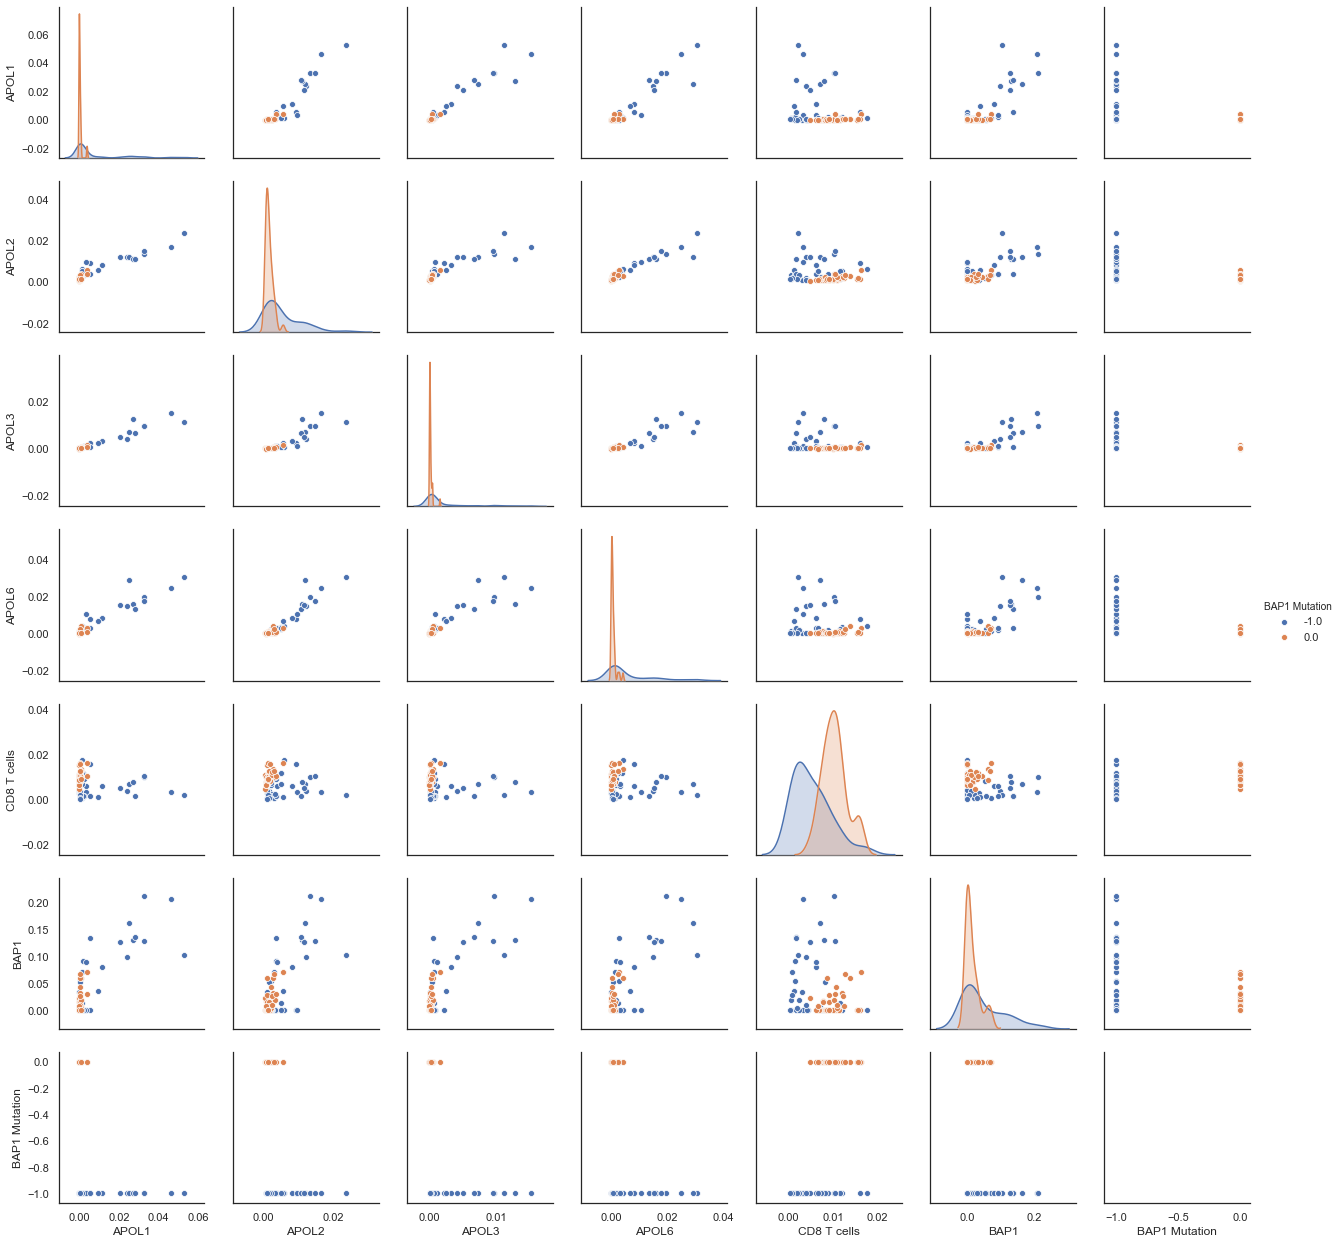

In [40]:
pairplot_df = pd.DataFrame(columns=['APOL1', 'APOL2', 'APOL3', 'APOL6','CD8 T cells',"BAP1","BAP1 Mutation"])
for p in list(gene_expression.index):
    l = list(gene_expression.loc[p,['APOL1', 'APOL2', 'APOL3', 'APOL6',"BAP1"]].values)
    l.extend(immune_fractions_df.loc[p,['CD8 T cells']])
    l.extend([patient_dict[p]["BAP1_mutation"]])
    pairplot_df.loc[p] = l
pairplot_df.head()
sns.pairplot(pairplot_df,hue="BAP1 Mutation")

## Cluster Patients Based off of Immune Fractions

### Clustering and Determining Makeup

In [41]:
immune_dataframes = cluster_gene_variance(immune_fractions_df,variance_threshold=.0000001,pca_components=3,n_clusters=4)

Tot Explained Var (PCA):  0.8499397018622531
Frac Var Exp (k-menas):  0.6881745752192912
Counter({0: 29, 3: 22, 1: 15, 2: 14})


In [42]:
immune_ids = [list(immune_dataframes[i].index) for i in range(len(immune_dataframes))]

In [43]:
print("Percentage of total BAP1 -1 by cluster: ",[sum([1 for p in immune_ids[i] if patient_dict[p]['BAP1_mutation'] == -1])/44 for i in range(len(immune_ids))])
print("Percentage of total BAP1 0 by cluster: ",[sum([1 for p in immune_ids[i] if patient_dict[p]['BAP1_mutation'] == 0])/26 for i in range(len(immune_ids))])
print("Percentage of BAP1 -1 by cluster: ",[sum([1 for p in immune_ids[i] if patient_dict[p]['BAP1_mutation'] == -1])/len(immune_ids[i]) for i in range(len(immune_ids))])
print("Percentage of BAP1 0 by cluster: ",[sum([1 for p in immune_ids[i] if patient_dict[p]['BAP1_mutation'] == 0])/len(immune_ids[i]) for i in range(len(immune_ids))])

Percentage of total BAP1 -1 by cluster:  [0.29545454545454547, 0.11363636363636363, 0.25, 0.3409090909090909]
Percentage of total BAP1 0 by cluster:  [0.6153846153846154, 0.38461538461538464, 0.11538461538461539, 0.2692307692307692]
Percentage of BAP1 -1 by cluster:  [0.4482758620689655, 0.3333333333333333, 0.7857142857142857, 0.6818181818181818]
Percentage of BAP1 0 by cluster:  [0.5517241379310345, 0.6666666666666666, 0.21428571428571427, 0.3181818181818182]


In [44]:
[sum([1 for p in immune_ids[i] if patient_dict[p]['BAP1_mutation'] == -1]) for i in range(4)]

[13, 5, 11, 15]

### Plot Group Immune Cell  Fractions

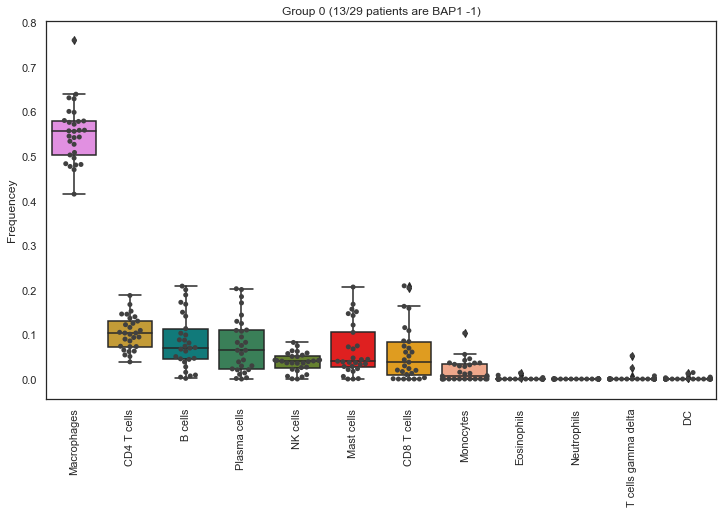

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [45]:
cell_frequency_boxplot(immune_fractions_df_uncombined.loc[immune_ids[0]], "Group 0 (13/29 patients are BAP1 -1)")

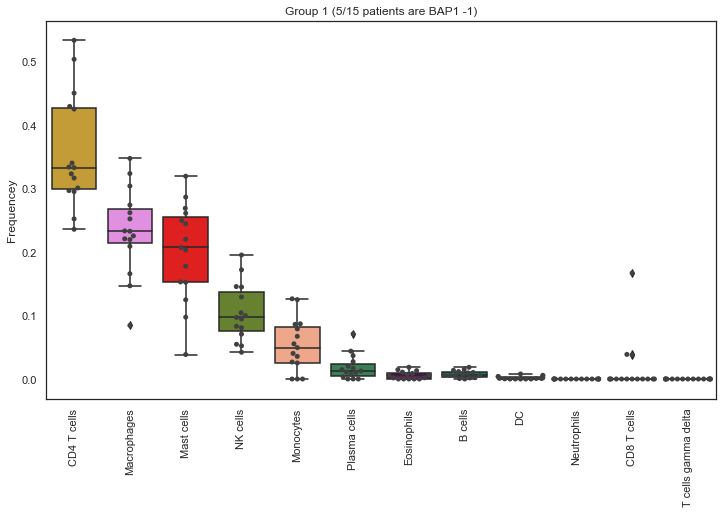

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [46]:
cell_frequency_boxplot(immune_fractions_df_uncombined.loc[immune_ids[1]], "Group 1 (5/15 patients are BAP1 -1)")

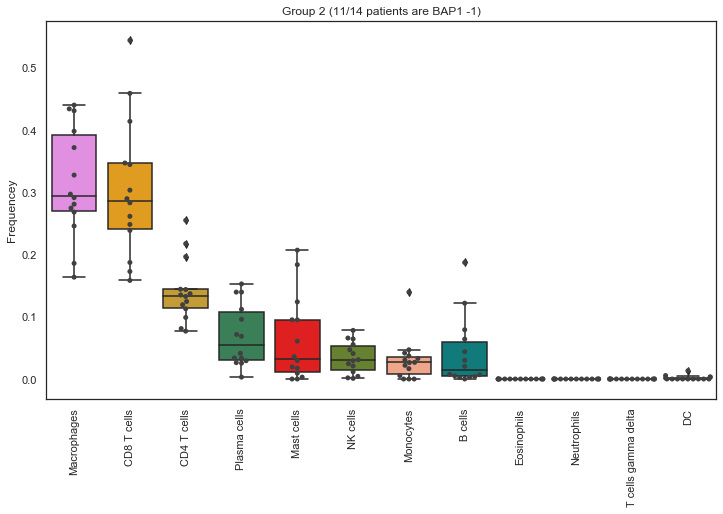

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [47]:
cell_frequency_boxplot(immune_fractions_df_uncombined.loc[immune_ids[2]], "Group 2 (11/14 patients are BAP1 -1)")

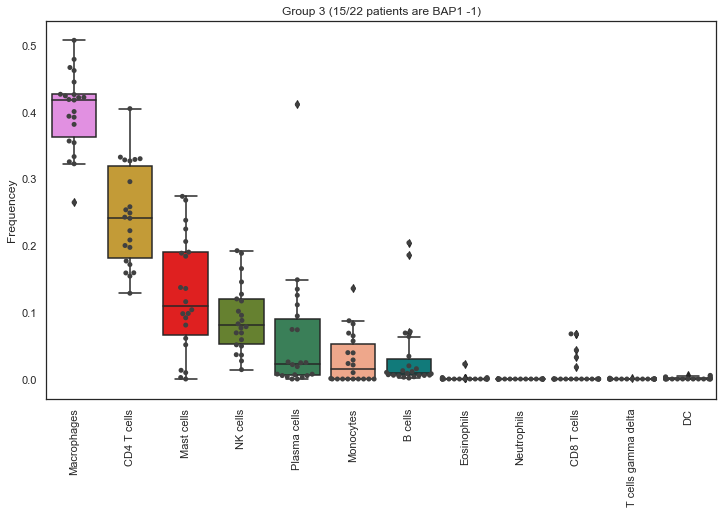

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [48]:
cell_frequency_boxplot(immune_fractions_df_uncombined.loc[immune_ids[3]], "Group 3 (15/22 patients are BAP1 -1)")

In [49]:
print_significant_immune_differences(immune_fractions_df,immune_ids)

B cells  difference between groups  0   1  p-value:  2.610252168632779e-06
B cells  difference between groups  0   2  p-value:  0.004260765651343693
B cells  difference between groups  0   3  p-value:  0.0003433678849465383
B cells  difference between groups  1   3  p-value:  0.0230067458877995
CD4 T cells  difference between groups  0   1  p-value:  4.445941112620001e-08
CD4 T cells  difference between groups  0   2  p-value:  0.019676339486297146
CD4 T cells  difference between groups  0   3  p-value:  7.655823488184015e-09
CD4 T cells  difference between groups  1   2  p-value:  4.7155193170173765e-06
CD4 T cells  difference between groups  1   3  p-value:  0.005353959210515871
CD4 T cells  difference between groups  2   3  p-value:  6.019702949101418e-05
CD8 T cells  difference between groups  0   1  p-value:  0.0003160269774120893
CD8 T cells  difference between groups  0   2  p-value:  2.972675428548457e-07
CD8 T cells  difference between groups  0   3  p-value:  4.68297922113952

We want to see if there are 4 distinct groups where there is a statistically significant difference between immune cell types. So for this we will first look at groups which have 6 tests which reject the null hypothesis.

- CD4 T cells
- Macrophages

Next 5 rejected hypothesises
- CD8 T cells
- Mast Cells

### Plot Significant Differences Between Groups

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1324: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1328: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


Text(0, 0.5, 'Immune Cell Fraction')

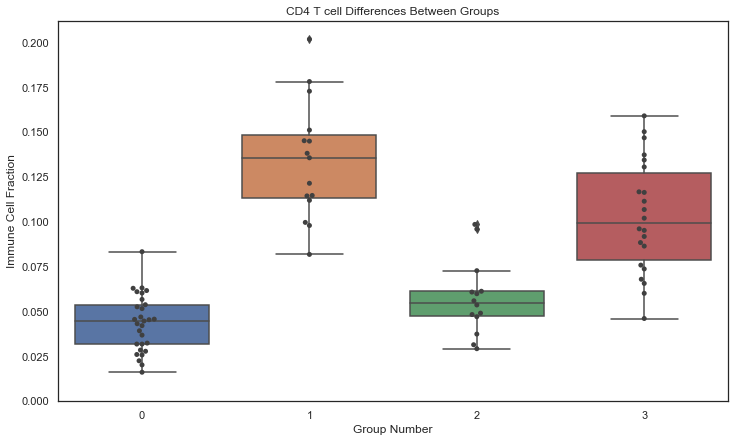

In [50]:
y = [list(immune_fractions_df.loc[immune_ids[i],"CD4 T cells"].values) for i in range(4)]
temp_df = pd.DataFrame(data=y)
sns.swarmplot( data=temp_df.T,color=".25")
sns.boxplot(data=temp_df.T)
plt.title("CD4 T cell Differences Between Groups")
plt.xlabel("Group Number")
plt.ylabel("Immune Cell Fraction")

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1324: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1328: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


Text(0, 0.5, 'Immune Cell Fraction')

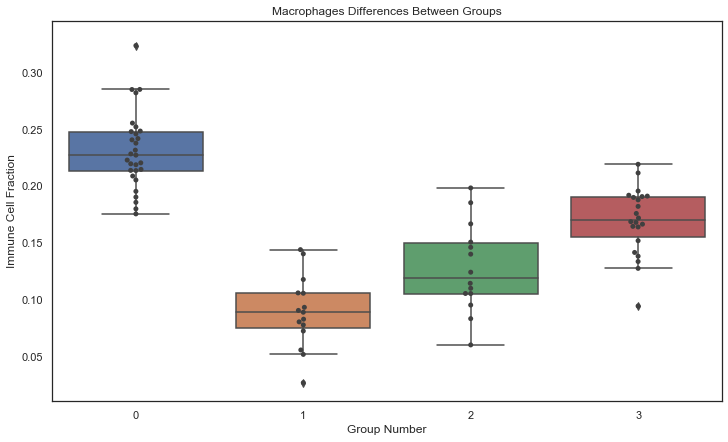

In [51]:
y = [list(immune_fractions_df.loc[immune_ids[i],"Macrophages"].values) for i in range(4)]
temp_df = pd.DataFrame(data=y)
sns.swarmplot( data=temp_df.T,color=".25")
sns.boxplot(data=temp_df.T)
plt.title("Macrophages Differences Between Groups")
plt.xlabel("Group Number")
plt.ylabel("Immune Cell Fraction")

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1324: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1328: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


Text(0, 0.5, 'Immune Cell Fraction')

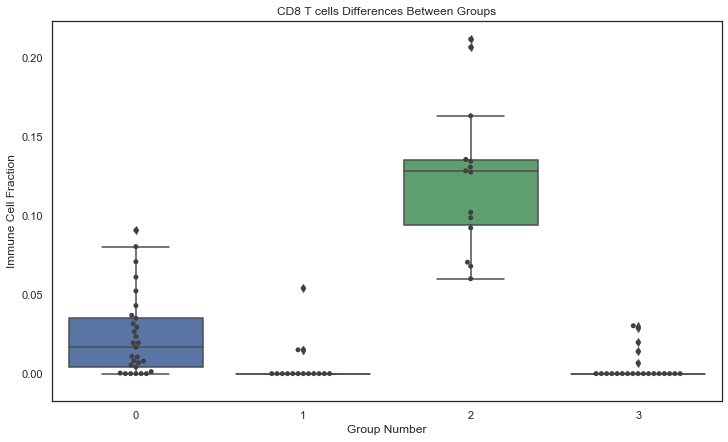

In [52]:
y = [list(immune_fractions_df.loc[immune_ids[i],"CD8 T cells"].values) for i in range(4)]
temp_df = pd.DataFrame(data=y)
sns.swarmplot( data=temp_df.T,color=".25")
sns.boxplot(data=temp_df.T)
plt.title("CD8 T cells Differences Between Groups")
plt.xlabel("Group Number")
plt.ylabel("Immune Cell Fraction")

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1324: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1328: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


Text(0, 0.5, 'Immune Cell Fraction')

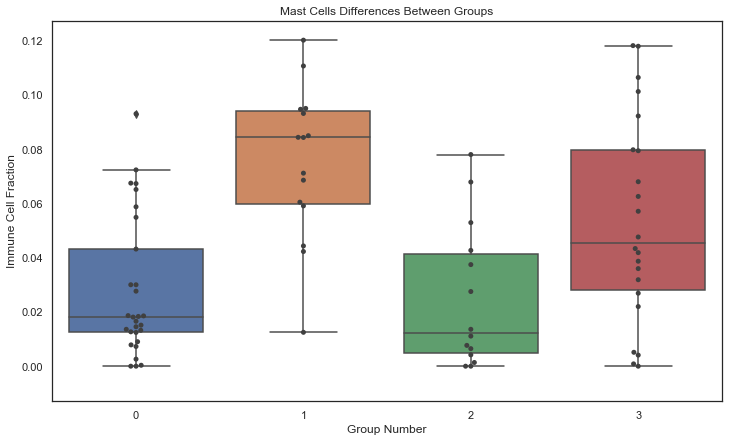

In [53]:
y = [list(immune_fractions_df.loc[immune_ids[i],"Mast cells"].values) for i in range(4)]
temp_df = pd.DataFrame(data=y)
sns.swarmplot( data=temp_df.T,color=".25")
sns.boxplot(data=temp_df.T)
plt.title("Mast Cells Differences Between Groups")
plt.xlabel("Group Number")
plt.ylabel("Immune Cell Fraction")

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1324: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1328: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


Text(0, 0.5, 'Immune Cell Fraction')

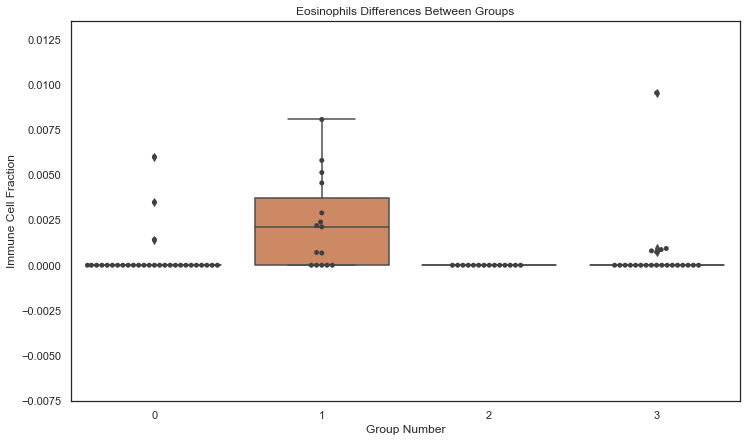

In [54]:
y = [list(immune_fractions_df.loc[immune_ids[i],"Eosinophils"].values) for i in range(4)]
temp_df = pd.DataFrame(data=y)
sns.swarmplot( data=temp_df.T,color=".25")
sns.boxplot(data=temp_df.T)
plt.title("Eosinophils Differences Between Groups")
plt.xlabel("Group Number")
plt.ylabel("Immune Cell Fraction")

Looking at these plots there are super interesitng differences between CD8 T cells between many of the groups. I wonder how the differences would look if I combined groups 1 and 3. Group two seems to be a huge outlier for CD8 T cells and somewhat average for Macrophages. Interestingly enough [0.4482758620689655, 0.3333333333333333, 0.7857142857142857, 0.6818181818181818] here are the percentages of BAP1 by group (# bap1 -1/group size). Group 2 which is the outlier in CD8 T cells has the highest percentage of BAP1 -1 patients. However since group 3 has almost no CD8 T cells its kinda weird because it has teh 2nd highest fraction of BAP1 -1 patients. Something else must be at play here. I am going to compare patients in group 2 with previous clustering attempts to see if there is any overlap and if I can gain any other insight.

In [55]:
print([sum([1 if p in grouped_ids[2] else 0 for p in immune_ids[i]])/len(immune_ids[i]) for i in range(4)])

[0.034482758620689655, 0.06666666666666667, 0.5714285714285714, 0.18181818181818182]


Immune group 2 and expression group 2 have the highest overlap which is interesting because expresison group 2 had the highest levels of CD8 T cells so its expected that they share a lot of their patients. About half of patients in groups 0 and 3 belong to expresison group 1. There wasnt much overlap for group 0. Since there isnt a ton of overlap I will do a seperate analysis of these immune groups as I did above to see whats going on with group 2 and to see what genes are responsible for it. If the APOL family shows up here again it will be very interesting. 

In [56]:
[len(i) for i in immune_ids]

[29, 15, 14, 22]

### APOL6 Analysis

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1324: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1328: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


Text(0, 0.5, 'Normalized Expression Value')

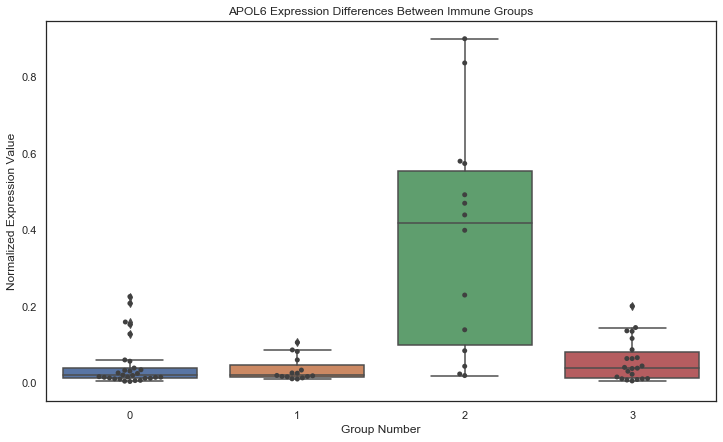

In [57]:
y = [list(gene_expression.loc[immune_ids[i],"CD74"].values) for i in range(4)]
temp_df = pd.DataFrame(data=y)
sns.swarmplot( data=temp_df.T,color=".25")
sns.boxplot(data=temp_df.T)
plt.title("APOL6 Expression Differences Between Immune Groups")
plt.xlabel("Group Number")
plt.ylabel("Normalized Expression Value")

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1324: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1328: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


Text(0, 0.5, 'Normalized Expression Value')

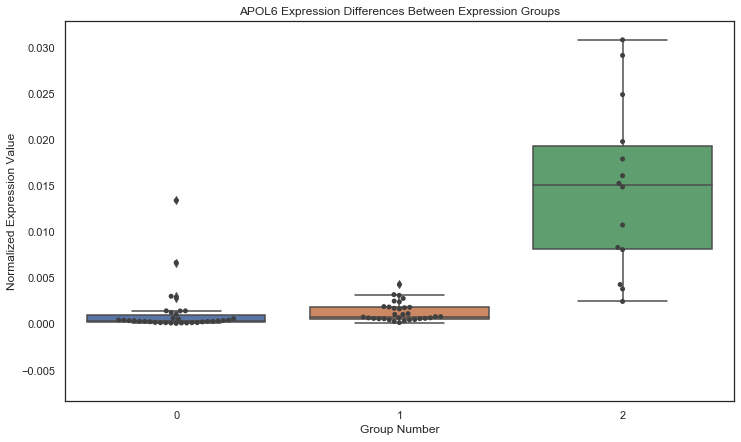

In [58]:
y = [list(gene_expression.loc[grouped_ids[i],"APOL6"].values) for i in range(3)]
temp_df = pd.DataFrame(data=y)
sns.swarmplot(data=temp_df.T,color=".25")
sns.boxplot(data=temp_df.T)
plt.title("APOL6 Expression Differences Between Expression Groups")
plt.xlabel("Group Number")
plt.ylabel("Normalized Expression Value")

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1324: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1328: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


Text(0, 0.5, 'Normalized Expression Value')

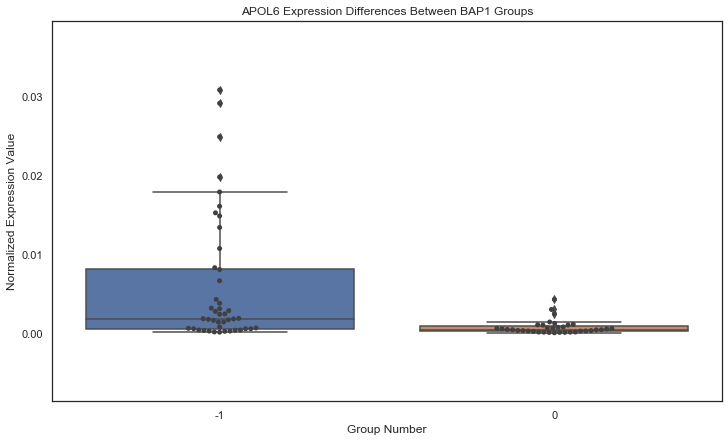

In [59]:
y = [list(gene_expression.loc[bap1_grouped_ids[i],"APOL6"].values) for i in range(2)]
temp_df = pd.DataFrame(data=y).T
temp_df.columns = ["-1", "0"]
sns.swarmplot( data=temp_df,color=".25")
sns.boxplot(data=temp_df)
plt.title("APOL6 Expression Differences Between BAP1 Groups")
plt.xlabel("Group Number")
plt.ylabel("Normalized Expression Value")

In [60]:
mannwhitneyu(y[0],y[1])

MannwhitneyuResult(statistic=343.0, pvalue=7.207759672269905e-06)

In [68]:
bap_ids = [[p for p in list(gene_expression.index) if patient_dict[p]['BAP1_mutation'] == i] for i in [0,-1]]

Text(0, 0.5, 'Normalized Expression Value')

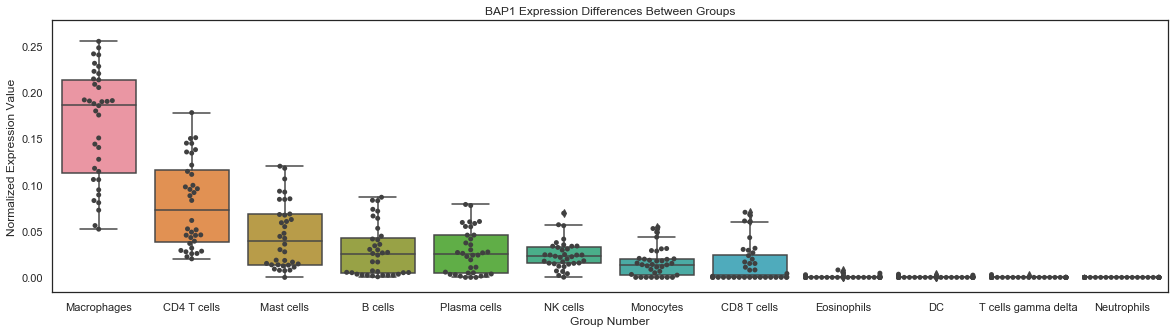

In [69]:
#y = [list(gene_expression.loc[immune_ids[i],"BAP1"].values) for i in range(4)]
y = [[patient_dict[p]["immune_fractions"] for p in bap_ids[i]] for i in range(2)]
temp_df = pd.DataFrame(data=y[0])
temp_df.columns=immune_fractions_df.columns
temp_df= temp_df.T.assign(m=temp_df.mean(axis=0)).sort_values('m',ascending=False).drop('m', axis=1).T
plt.figure(figsize=(20,5))
sns.swarmplot( data=temp_df,color=".25")
sns.boxplot(data=temp_df)
plt.title("BAP1 Expression Differences Between Groups")
plt.xlabel("Group Number")
plt.ylabel("Normalized Expression Value")

Text(0, 0.5, 'Normalized Expression Value')

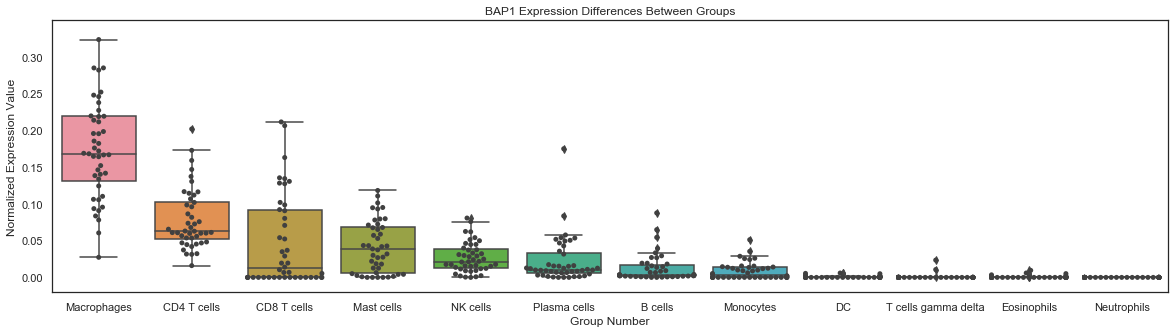

In [70]:

temp_df = pd.DataFrame(data=y[1])
temp_df.columns=immune_fractions_df.columns
temp_df= temp_df.T.assign(m=temp_df.mean(axis=0)).sort_values('m',ascending=False).drop('m', axis=1).T
plt.figure(figsize=(20,5))
sns.swarmplot( data=temp_df,color=".25")
sns.boxplot(data=temp_df)
plt.title("BAP1 Expression Differences Between Groups")
plt.xlabel("Group Number")
plt.ylabel("Normalized Expression Value")

Wow, this is a huge difference right where we wanted to see it. Now I am going to see, when condidioned on group 2, if there is a correlation between APOL6 and CD8 T cells. Afterwards, if there is I will see if there is a correlation conditioned on group 2 between CD8 T cells and any of the phenotypes. However I didnt expect BAP1 to be the lowest in group 2...

### Correlation Between APOL6 and CD8 T cell Concentration in group 2 especially

SpearmanrResult(correlation=0.6615384615384616, pvalue=0.009975179240423711)


Text(0.5, 0, 'APOL6 Gene expression')

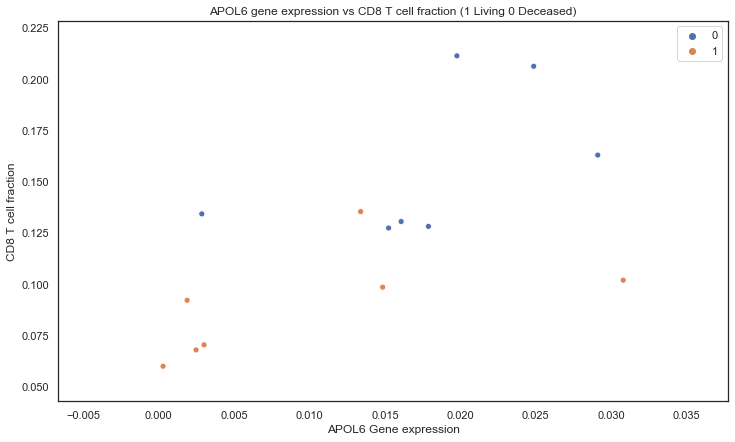

In [71]:
print(stats.spearmanr([gene_expression.loc[p,"APOL6"] for p in immune_ids[2]], [immune_fractions_df.loc[p,"CD8 T cells"] for p in immune_ids[2]]))
sns.scatterplot([gene_expression.loc[p,"APOL6"] for p in immune_ids[2]], [immune_fractions_df.loc[p,"CD8 T cells"] for p in immune_ids[2]],hue=[patient_dict[p]["os_status"] for p in immune_ids[2]])
plt.title("APOL6 gene expression vs CD8 T cell fraction (1 Living 0 Deceased)")
plt.ylabel("CD8 T cell fraction")
plt.xlabel("APOL6 Gene expression")

As expected with a R of .712656 and a p value of .004230. Now I will test with this same group to see if there is a correlation between CD8 T cells and other phenotypes.

### Correlation Between CD8 T cell immune fraction and various patient phenotypes

In [72]:
print(stats.pearsonr([immune_fractions_df.loc[p,"CD8 T cells"] for p in immune_ids[3]],[patient_dict[p]["os_status"] for p in immune_ids[3]]))

(-0.177164409758005, 0.4302648213831288)


Results:

| Dependent Variable | R | P-value |
|--------------------|---|---------|
| Age | .179653 |.53884 |
| Tumor Basal Radius | .331623 | .246746|
| Disease Specific Survival time | .539157 | .04663 |
| OS_status | -0.7516 | .001936 |

Two statistically significant differences!! I will show plots of the two stat significant results to see whats going on.

Text(0.5, 0, 'CD8 T cell immune fraction')

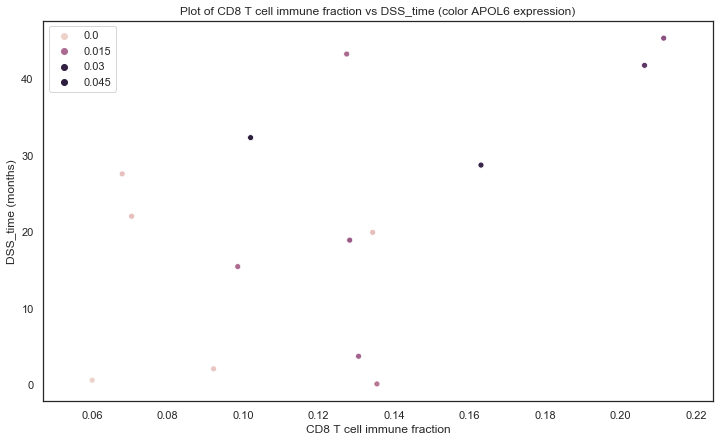

In [73]:
sns.scatterplot([immune_fractions_df.loc[p,"CD8 T cells"] for p in immune_ids[2]],[patient_dict[p]["DSS_time"] for p in immune_ids[2]],hue=[gene_expression.loc[p,"APOL6"] for p in immune_ids[2]])
plt.title("Plot of CD8 T cell immune fraction vs DSS_time (color APOL6 expression)")
plt.ylabel("DSS_time (months)")
plt.xlabel("CD8 T cell immune fraction")

Text(0.5, 0, 'CD8 T cell immune fraction')

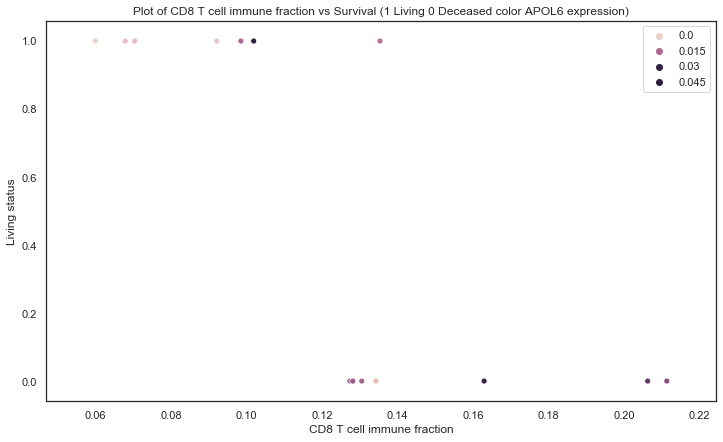

In [74]:
sns.scatterplot([immune_fractions_df.loc[p,"CD8 T cells"] for p in immune_ids[2]],[patient_dict[p]["os_status"] for p in immune_ids[2]],hue=[gene_expression.loc[p,"APOL6"] for p in immune_ids[2]])
plt.title("Plot of CD8 T cell immune fraction vs Survival (1 Living 0 Deceased color APOL6 expression)")
plt.ylabel("Living status")
plt.xlabel("CD8 T cell immune fraction")

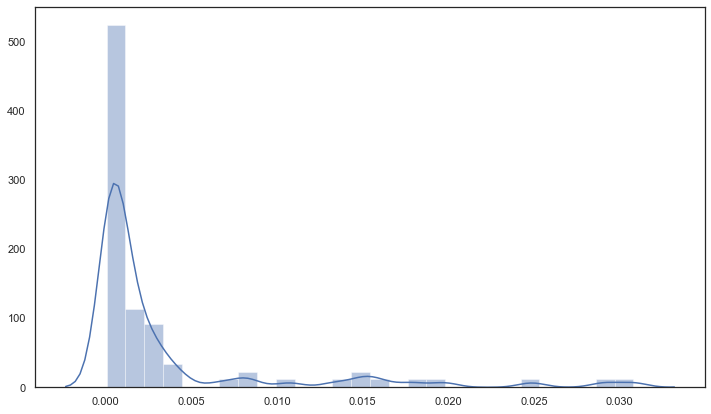

In [75]:
sns.distplot([gene_expression.loc[p,"APOL6"] for p in list(gene_expression.index)])
#sns.scatterplot([gene_expression.loc[p,"APOL6"] for p in list(gene_expression.index)],hue=[presence_df.T.loc[p,"APOL6"] for p in list(presence_df.T.index)])

In [76]:
stats.pearsonr([gene_expression.loc[p,"BAP1"] for p in immune_ids[2]], [immune_fractions_df.loc[p,"CD8 T cells"] for p in immune_ids[2]])

(-0.2455521378557129, 0.39745223411779784)

Text(0, 0.5, 'APOL6 Expression')

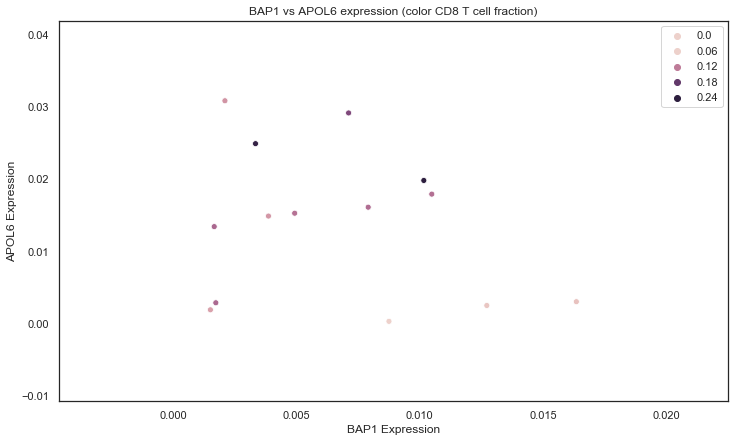

In [77]:
sns.scatterplot([gene_expression.loc[p,"BAP1"] for p in immune_ids[2]],[gene_expression.loc[p,"APOL6"] for p in immune_ids[2]], hue=[immune_fractions_df.loc[p,"CD8 T cells"] for p in immune_ids[2]])
plt.title("BAP1 vs APOL6 expression (color CD8 T cell fraction)")
plt.xlabel("BAP1 Expression")
plt.ylabel("APOL6 Expression")

### Group Phenotype differences

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1324: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1328: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


Text(0, 0.5, 'Months of survival')

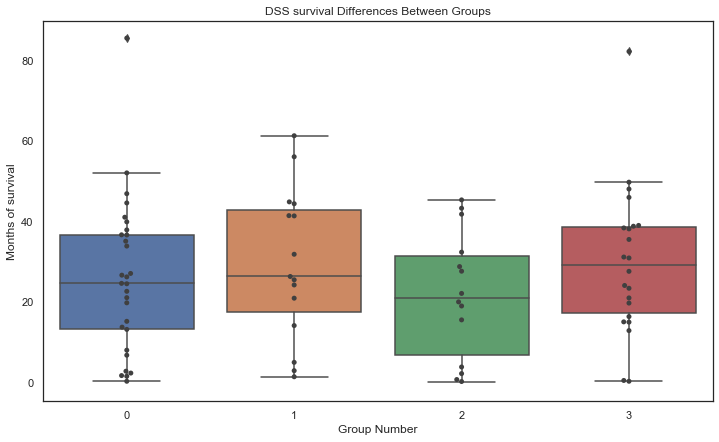

In [78]:
y = [[patient_dict[p]["DSS_time"] for p in immune_ids[i]] for i in range(4)]
temp_df = pd.DataFrame(data=y)
sns.swarmplot( data=temp_df.T,color=".25")
sns.boxplot(data=temp_df.T)
plt.title("DSS survival Differences Between Groups")
plt.xlabel("Group Number")
plt.ylabel("Months of survival")

In [79]:
print(mannwhitneyu([patient_dict[p]["DSS_time"] for p in immune_ids[2]],[patient_dict[p]["DSS_time"] for p in immune_ids[0]]))
print(mannwhitneyu([patient_dict[p]["DSS_time"] for p in immune_ids[2]],[patient_dict[p]["DSS_time"] for p in immune_ids[1]]))
print(mannwhitneyu([patient_dict[p]["DSS_time"] for p in immune_ids[2]],[patient_dict[p]["DSS_time"] for p in immune_ids[3]]))

MannwhitneyuResult(statistic=182.0, pvalue=0.2975989627884811)
MannwhitneyuResult(statistic=80.0, pvalue=0.14247453884232747)
MannwhitneyuResult(statistic=121.0, pvalue=0.14579859843964144)


No stat significant difference between DSS

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1324: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1328: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


Text(0, 0.5, 'Age of diagnosis')

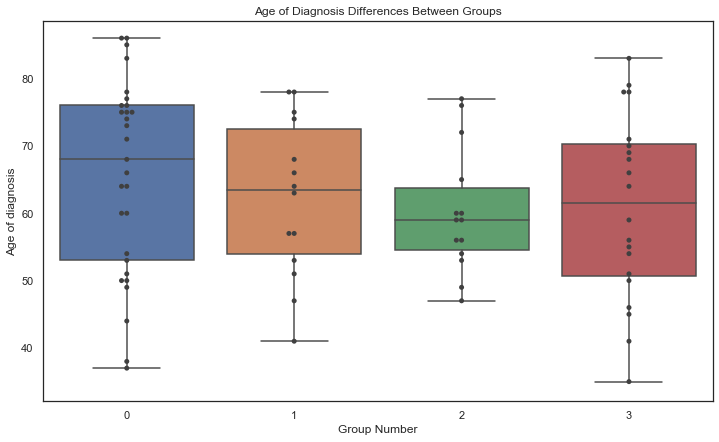

In [80]:
y = [[patient_dict[p]["age"] for p in immune_ids[i]] for i in range(4)]
temp_df = pd.DataFrame(data=y)
sns.swarmplot( data=temp_df.T,color=".25")
sns.boxplot(data=temp_df.T)
plt.title("Age of Diagnosis Differences Between Groups")
plt.xlabel("Group Number")
plt.ylabel("Age of diagnosis")

In [81]:
print(mannwhitneyu([patient_dict[p]["age"] for p in immune_ids[2]],[patient_dict[p]["age"] for p in immune_ids[0]]))
print(mannwhitneyu([patient_dict[p]["age"] for p in immune_ids[2]],[patient_dict[p]["age"] for p in immune_ids[1]]))
print(mannwhitneyu([patient_dict[p]["age"] for p in immune_ids[2]],[patient_dict[p]["age"] for p in immune_ids[3]]))

MannwhitneyuResult(statistic=153.0, pvalue=0.09952723036999478)
MannwhitneyuResult(statistic=85.0, pvalue=0.19716688714479275)
MannwhitneyuResult(statistic=135.5, pvalue=0.27943744481386645)


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1324: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1328: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


Text(0, 0.5, 'Age of diagnosis')

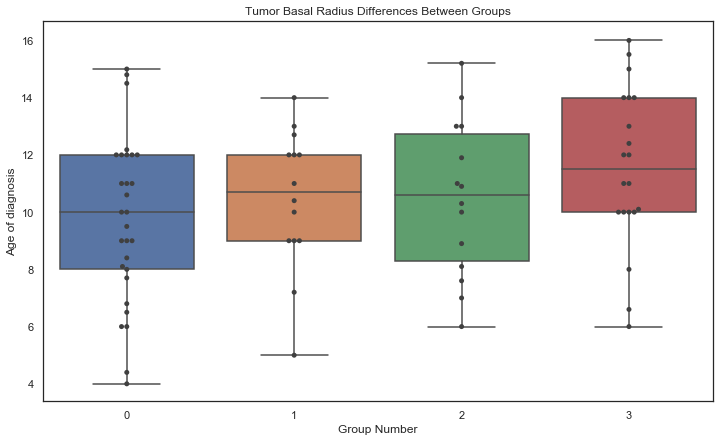

In [82]:
y = [[patient_dict[p]["tumor_thickness"] for p in immune_ids[i] if patient_dict[p]["tumor_thickness"]] for i in range(4)]
temp_df = pd.DataFrame(data=y)
sns.swarmplot( data=temp_df.T,color=".25")
sns.boxplot(data=temp_df.T)
plt.title("Tumor Basal Radius Differences Between Groups")
plt.xlabel("Group Number")
plt.ylabel("Age of diagnosis")

### Look at Stages of Cancer

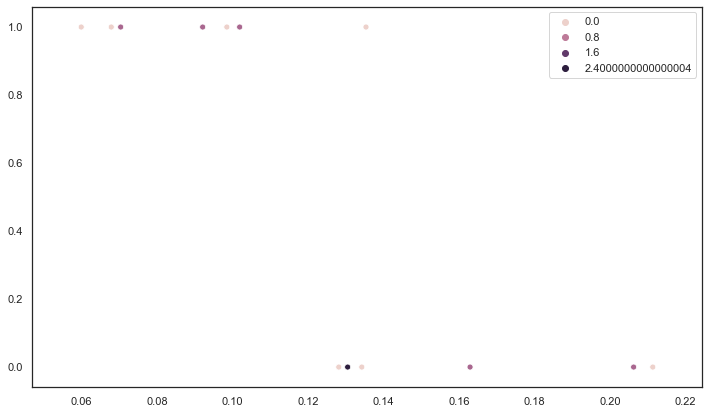

In [83]:
sns.scatterplot([immune_fractions_df.loc[p,"CD8 T cells"] for p in immune_ids[2]],[patient_dict[p]["os_status"] for p in immune_ids[2]],hue=[patient_dict[p]["stage"] for p in immune_ids[2]])

In [84]:
Counter([patient_dict[p]["stage"] for p in immune_ids[2]])

Counter({0: 7, 1: 5, 2: 1, nan: 1})

In [85]:
Counter([patient_dict[p]["stage"] for p in list(patient_dict.keys())])

Counter({2: 4, 0: 37, 1: 35, nan: 4})

### Find most variant genes amongst group 2

In [86]:
most_variant = td.variance_threshold_selector(gene_expression.loc[immune_ids[2]].T, threshold=0.03).T
most_variant.assign(m=most_variant.var(axis=1)).sort_values('m').drop('m', axis=1)
 
most_variant.head()

Hugo_Symbol,ADAM6,B2M,CD74,EEF2,GAPDH,HLA-A,HLA-B,HLA-C,PABPC1,RPL13,RPL8,RPS18,SILV,TYRP1,VIM
TCGA-V3-A9ZX-01,0.000496,0.331671,0.229590,0.770344,0.486198,0.670995,0.520431,0.245317,0.666877,0.125453,0.886264,0.367700,1.000000,0.267947,0.443473
TCGA-V4-A9EH-01,0.002243,0.238683,0.043474,0.358201,0.199605,0.205213,0.249123,0.140250,0.085756,0.322494,0.257401,0.168286,1.000000,0.382534,0.686556
TCGA-V4-A9EL-01,0.163687,0.773246,0.491802,0.544438,0.648023,1.000000,0.851994,0.439749,0.671029,0.117047,0.810183,0.240998,0.190667,0.042058,0.435034
TCGA-V4-A9EV-01,0.002817,0.618434,0.899672,0.405770,0.477072,0.672883,1.000000,0.735321,0.437109,0.167613,0.470892,0.169916,0.367653,0.475242,0.369309
TCGA-V4-A9F3-01,0.039695,0.609913,0.439055,0.761632,0.468000,1.000000,0.969504,0.724745,0.629523,0.183623,0.568201,0.363167,0.704484,0.371162,0.906017


Text(0, 0.5, 'APOL6 Expression')

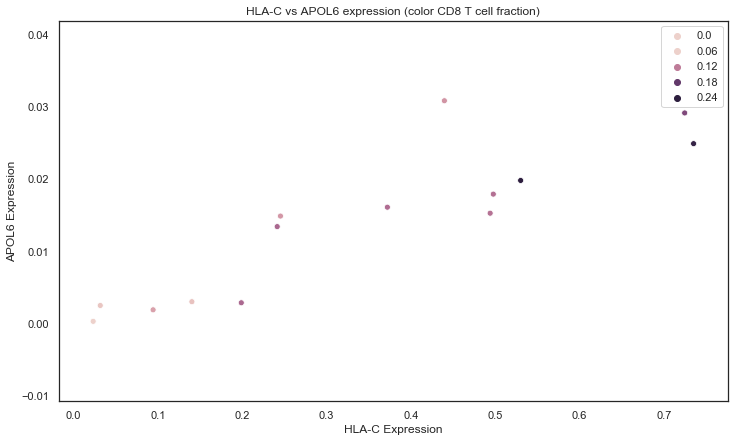

In [87]:
sns.scatterplot([gene_expression.loc[p,"HLA-C"] for p in immune_ids[2]],[gene_expression.loc[p,"APOL6"] for p in immune_ids[2]], hue=[immune_fractions_df.loc[p,"CD8 T cells"] for p in immune_ids[2]])
plt.title("HLA-C vs APOL6 expression (color CD8 T cell fraction)")
plt.xlabel("HLA-C Expression")
plt.ylabel("APOL6 Expression")

In [88]:
highest_var =[]
y = [immune_fractions_df.loc[p,"CD8 T cells"] for p in immune_ids[2]]
for gene in most_variant.columns[:100]:
    x = [[most_variant.loc[p,gene],gene_expression.loc[p,"APOL6"]] for p in immune_ids[2]]
    cor, pv = stats.spearmanr(x,y)
    highest_var.append((gene,np.mean(cor),np.mean(pv)))
highest_var = sorted(highest_var, key=lambda g: g[1], reverse=True)
print(highest_var[:5])

[('HLA-C', 0.8612942612942613, 0.0023415526562138443), ('HLA-B', 0.859757829284228, 0.002289463079673022), ('B2M', 0.8495726495726497, 0.003374909293535461), ('CD74', 0.8290598290598292, 0.002662338427254696), ('HLA-A', 0.7962635269543858, 0.009146990248014039)]


Text(0, 0.5, 'APOL6 Expression')

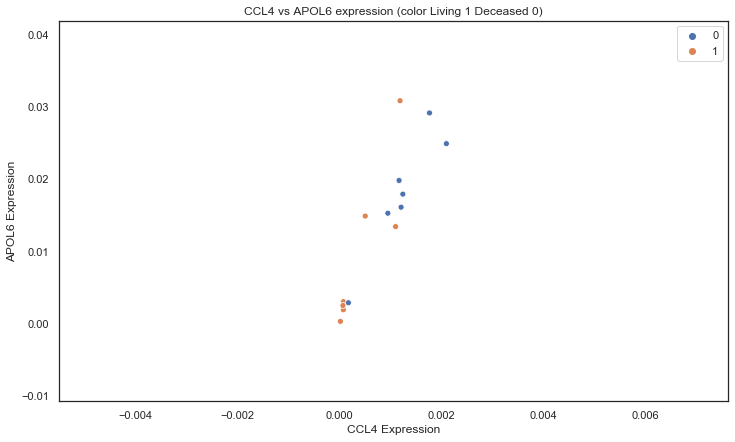

In [89]:
sns.scatterplot([gene_expression.loc[p,"CCL4"] for p in immune_ids[2]],[gene_expression.loc[p,"APOL6"] for p in immune_ids[2]], hue=[patient_dict[p]["os_status"] for p in immune_ids[2]])
plt.title("CCL4 vs APOL6 expression (color Living 1 Deceased 0)")
plt.xlabel("CCL4 Expression")
plt.ylabel("APOL6 Expression")

Text(0, 0.5, 'APOL6 Expression')

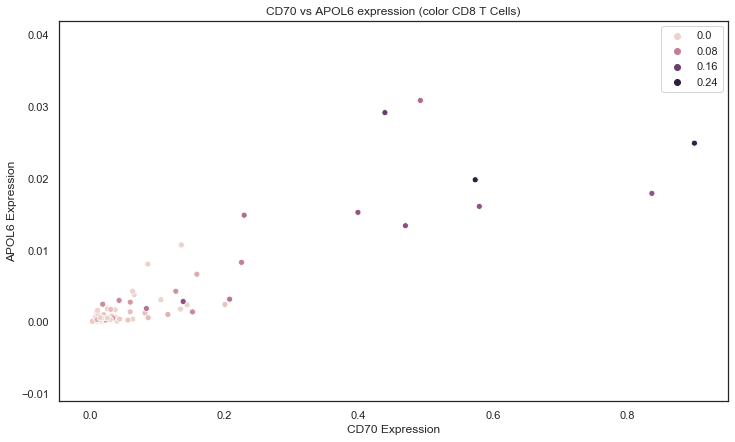

In [90]:
sns.scatterplot([gene_expression.loc[p,"CD74"] for p in list(patient_dict.keys())],[gene_expression.loc[p,"APOL6"] for p in list(patient_dict.keys())], hue=[immune_fractions_df.loc[p,"CD8 T cells"] for p in list(patient_dict.keys())])
plt.title("CD70 vs APOL6 expression (color CD8 T Cells)")
plt.xlabel("CD70 Expression")
plt.ylabel("APOL6 Expression")

Text(0, 0.5, 'APOL6 Expression')

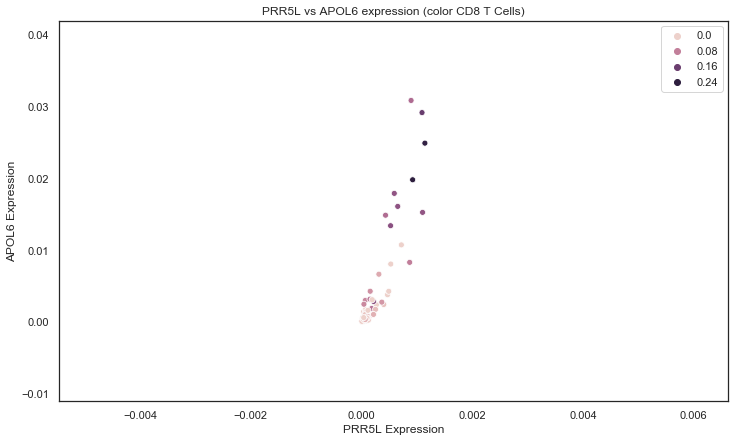

In [91]:
sns.scatterplot([gene_expression.loc[p,"PRR5L"] for p in list(patient_dict.keys())],[gene_expression.loc[p,"APOL6"] for p in list(patient_dict.keys())], hue=[immune_fractions_df.loc[p,"CD8 T cells"] for p in list(patient_dict.keys())])
plt.title("PRR5L vs APOL6 expression (color CD8 T Cells)")
plt.xlabel("PRR5L Expression")
plt.ylabel("APOL6 Expression")

In [92]:
stats.pearsonr([gene_expression.loc[p,"APOL6"] for p in list(patient_dict.keys())],[immune_fractions_df.loc[p,"CD8 T cells"] for p in list(patient_dict.keys())])

(0.7842398054047225, 7.731676190975264e-18)

In [93]:
y = [[immune_fractions_df.loc[p,"CD8 T cells"] for p in list(gene_expression.index) if patient_dict[p]["os_status"] == i] for i in range(2)]
mannwhitneyu(y[0],y[1])

MannwhitneyuResult(statistic=394.0, pvalue=0.0019417266692595256)

Text(0, 0.5, 'APOL6 Expression')

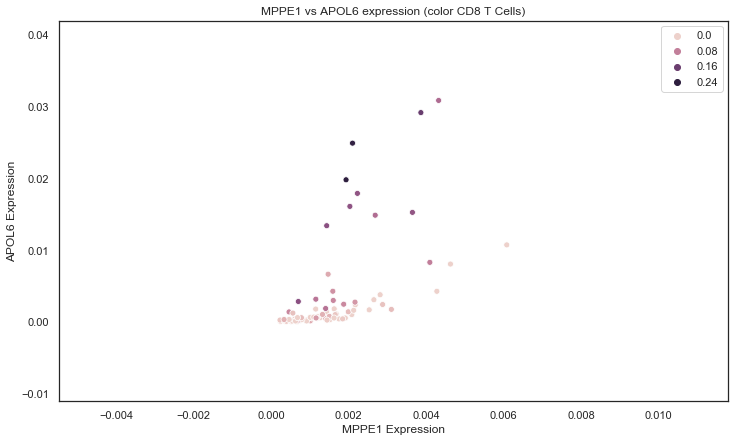

In [94]:
sns.scatterplot([gene_expression.loc[p,"MPPE1"] for p in list(patient_dict.keys())],[gene_expression.loc[p,"APOL6"] for p in list(patient_dict.keys())], hue=[immune_fractions_df.loc[p,"CD8 T cells"] for p in list(patient_dict.keys())])
plt.title("MPPE1 vs APOL6 expression (color CD8 T Cells)")
plt.xlabel("MPPE1 Expression")
plt.ylabel("APOL6 Expression")

In [95]:
highest_var =[]
y = [immune_fractions_df.loc[p,"CD8 T cells"] for p in immune_ids[2]]
for gene in most_variant.columns[:500]:
    x = [[gene_expression.loc[p,gene],gene_expression.loc[p,"APOL6"]] for p in immune_ids[2]]
    cor, pv = stats.spearmanr(x,y)
    highest_var.append((gene,np.mean(cor),np.mean(pv)))
highest_var = sorted(highest_var, key=lambda g: g[1], reverse=True)
print(highest_var[:15])

[('HLA-C', 0.8612942612942613, 0.0023415526562138443), ('HLA-B', 0.859757829284228, 0.002289463079673022), ('B2M', 0.8495726495726497, 0.003374909293535461), ('CD74', 0.8290598290598292, 0.002662338427254696), ('HLA-A', 0.7962635269543858, 0.009146990248014039), ('PABPC1', 0.7225885225885226, 0.057338970177124846), ('GAPDH', 0.6327228327228327, 0.118720413491479), ('RPL8', 0.5594627594627595, 0.26351279035160863), ('ADAM6', 0.5213675213675214, 0.3010439853706665), ('EEF2', 0.4998778998778999, 0.39431170354273554), ('RPL13', 0.49304029304029307, 0.3889489544453085), ('RPS18', 0.4920634920634921, 0.22203931443082614), ('TYRP1', 0.4642069237502599, 0.21924759554944398), ('VIM', 0.43052503052503055, 0.316078745513417), ('SILV', 0.19284629016391597, 0.007837769582557155)]


In [96]:
highest_var =[]
y = [immune_fractions_df.loc[p,"CD8 T cells"] for p in list(patient_dict.keys())]
for gene in most_variant.columns:
    if type(gene_expression.loc[:,gene]) != type(pd.DataFrame()) :
        x = [[gene_expression.loc[p,gene],gene_expression.loc[p,"APOL6"]] for p in list(patient_dict.keys())]
        lin = LinearRegression().fit(x,y)
        cor = lin.score(x,y)
        highest_var.append((gene,np.mean(cor),lin.coef_[0]))
highest_var = sorted(highest_var, key=lambda g: g[1], reverse=True)
print(highest_var[:15])

[('HLA-B', 0.7270815665467494, 0.2067811656993754), ('CD74', 0.7079757943450842, 0.17766017395183106), ('PABPC1', 0.6750888566103341, -0.07231198632430658), ('HLA-C', 0.6593245722783903, 0.18195981279894194), ('TYRP1', 0.6459333357300567, 0.032921184665689336), ('SILV', 0.6327436446731058, 0.035331875218756054), ('RPL8', 0.6255754453024085, -0.022366866093916353), ('EEF2', 0.6248481816813161, -0.020843339965769928), ('GAPDH', 0.623840485566143, -0.02134480547826125), ('ADAM6', 0.6237492790972237, 0.0302102927779336), ('HLA-A', 0.6222705306550591, 0.0441987639707559), ('B2M', 0.6184185565790081, 0.05280341190365368), ('RPL13', 0.6167976855819436, 0.013882114425443149), ('RPS18', 0.6164983178246644, -0.010524514506626663), ('VIM', 0.6150322052599925, -7.300583547852121e-05)]


In [97]:
highest_var = sorted(highest_var, key=lambda g: g[1], reverse=True)
print(highest_var[0][1]**.5)

0.8526907801464428


In [98]:
x = [[gene_expression.loc[p,"APOL6"]] for p in immune_ids[2]]
y = [immune_fractions_df.loc[p,"CD8 T cells"] for p in immune_ids[2]]
lin = LinearRegression().fit(x,y)
cor = lin.score(x,y)
print(cor)

0.403284928381726


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1324: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1328: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


Text(0, 0.5, 'Normalized Expression Value')

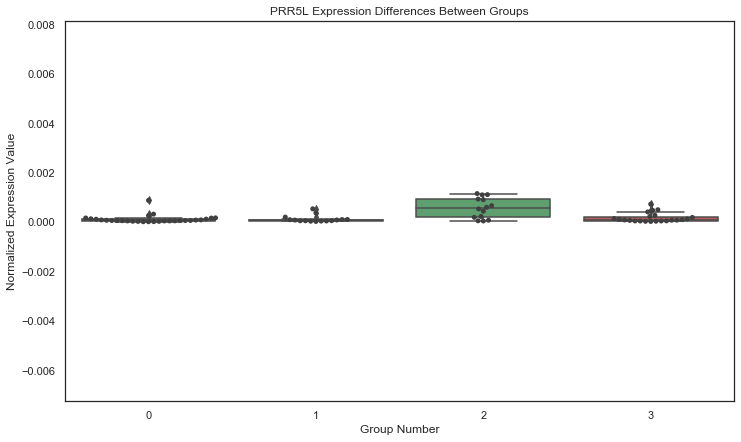

In [99]:
y = [list(gene_expression.loc[immune_ids[i],"PRR5L"].values) for i in range(4)]
temp_df = pd.DataFrame(data=y)
sns.swarmplot( data=temp_df.T,color=".25")
sns.boxplot(data=temp_df.T)
plt.title("PRR5L Expression Differences Between Groups")
plt.xlabel("Group Number")
plt.ylabel("Normalized Expression Value")

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1324: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1328: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


Text(0, 0.5, 'Normalized Expression Value')

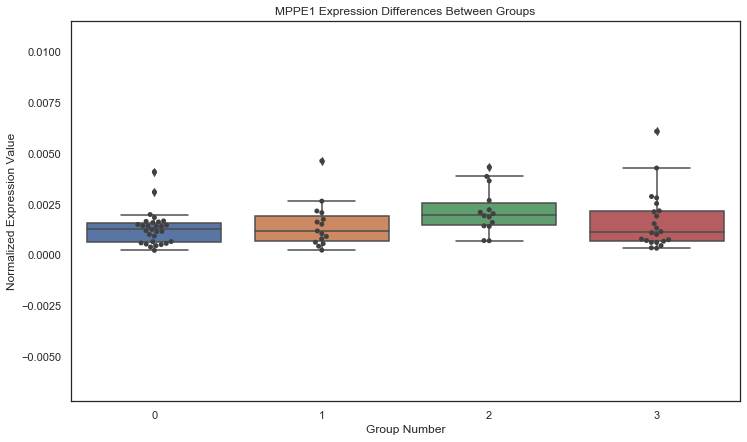

In [100]:
y = [list(gene_expression.loc[immune_ids[i],"MPPE1"].values) for i in range(4)]
temp_df = pd.DataFrame(data=y)
sns.swarmplot( data=temp_df.T,color=".25")
sns.boxplot(data=temp_df.T)
plt.title("MPPE1 Expression Differences Between Groups")
plt.xlabel("Group Number")
plt.ylabel("Normalized Expression Value")

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1324: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1328: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


Text(0, 0.5, 'Normalized Expression Value')

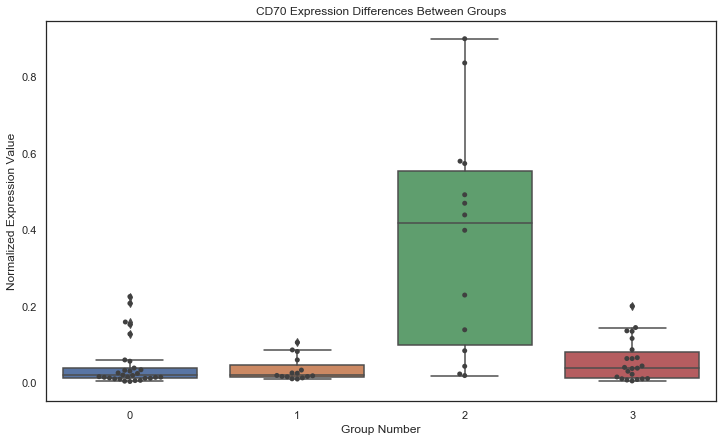

In [101]:
y = [list(gene_expression.loc[immune_ids[i],"CD74"].values) for i in range(4)]
temp_df = pd.DataFrame(data=y)
sns.swarmplot( data=temp_df.T,color=".25")
sns.boxplot(data=temp_df.T)
plt.title("CD70 Expression Differences Between Groups")
plt.xlabel("Group Number")
plt.ylabel("Normalized Expression Value")

In [102]:
Counter([presence_df.loc["CD70",p] for p in list(gene_expression.index)])

Counter({0: 73, 1: 2, -1: 4, -2: 1})

In [103]:
Counter([presence_df.loc["CD70",p] for p in immune_ids[2]])

Counter({0: 13, -1: 1})

## Week 6 Stuff

### BAP1 GROUP ANALYSIS

In [104]:
bap_ids = [[p for p in list(patient_dict.keys()) if patient_dict[p]["BAP1_mutation"] == i] for i in [0,-1]]

0 1 MannwhitneyuResult(statistic=727.5, pvalue=0.2678634403261627)


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1324: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1328: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


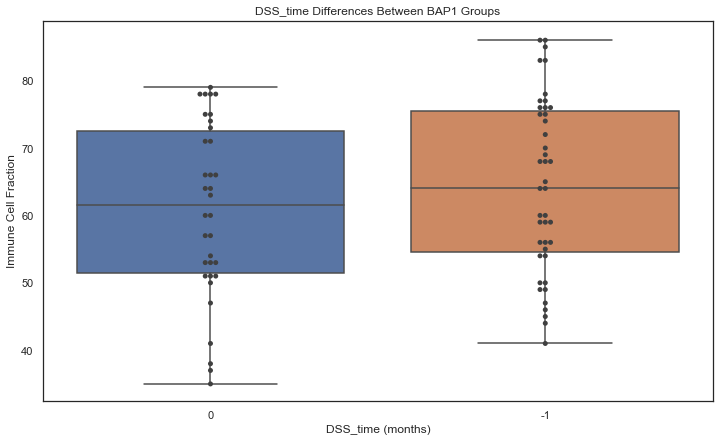

In [105]:
y= [[patient_dict[p]['age'] for p in bap_ids[i]] for i in range(2)]
#y = [list(immune_fractions_df.loc[immune_ids[i],"Eosinophils"].values) for i in range(4)]
temp_df = pd.DataFrame(data=y).T
temp_df.columns =["0","-1"]
sns.swarmplot( data=temp_df,color=".25")
sns.boxplot(data=temp_df)
plt.title("DSS_time Differences Between BAP1 Groups")
plt.xlabel("DSS_time (months)")
plt.ylabel("Immune Cell Fraction")
for c in combinations(range(2),2):
    print(c[0],c[1],mannwhitneyu([patient_dict[p]['age'] for p in bap_ids[c[0]]],[patient_dict[p]['age'] for p in bap_ids[c[1]]]))

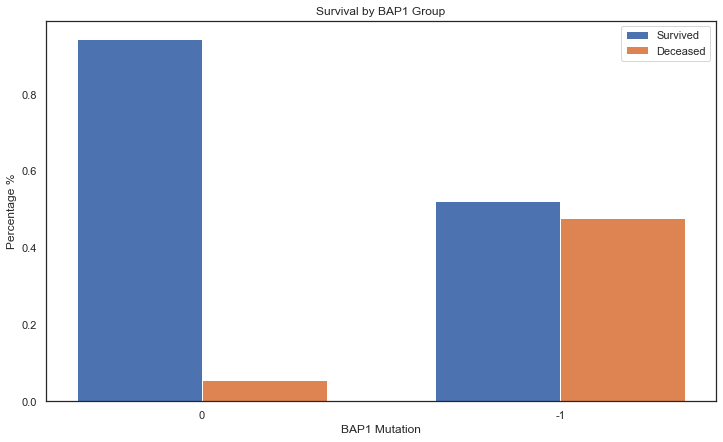

NameError: name 's1' is not defined

In [106]:
living_group= [sum([1 for p in bap_ids[i] if patient_dict[p]['os_status'] == 1])/len(bap_ids[i]) for  i in range(2)]
dead_group = [sum([1 for p in bap_ids[i] if patient_dict[p]['os_status'] == 0])/len(bap_ids[i]) for  i in range(2)]
v = [living_group,dead_group]
N = 2
ind = np.arange(N) 
width = 0.35       
plt.bar(ind, v[0], width, label='Survived')
plt.bar(ind + width, v[1], width,
    label='Deceased')

plt.ylabel('Percentage %')
plt.xlabel('BAP1 Mutation')
plt.title('Survival by BAP1 Group')

plt.xticks(ind + width / 2, ('0', '-1'))
plt.legend(loc='best')
plt.show()
print(proportions_ztest([s1,s2],[len(bap_ids[0]),len(bap_ids[1])]))

Text(0, 0.5, 'Fraction')

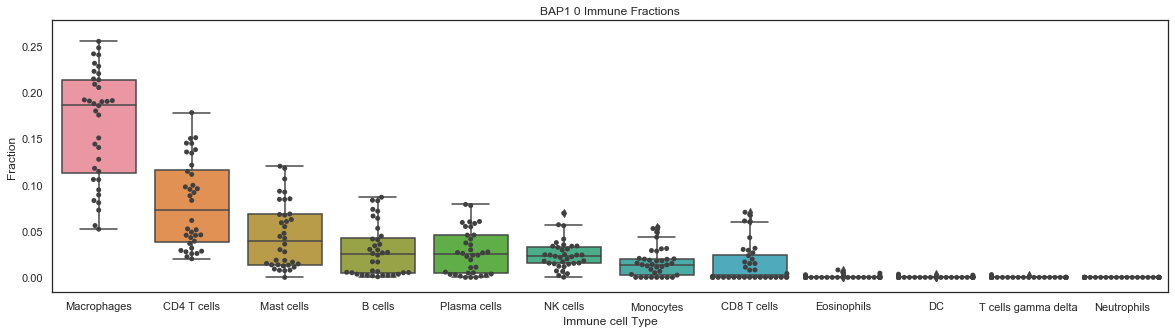

In [107]:
y = [[patient_dict[p]["immune_fractions"] for p in bap_ids[i]] for i in range(2)]
temp_df = pd.DataFrame(data=y[0])
temp_df.columns=immune_fractions_df.columns
temp_df= temp_df.T.assign(m=temp_df.mean(axis=0)).sort_values('m',ascending=False).drop('m', axis=1).T
plt.figure(figsize=(20,5))
sns.swarmplot( data=temp_df,color=".25")
sns.boxplot(data=temp_df)
plt.title("BAP1 0 Immune Fractions")
plt.xlabel("Immune cell Type")
plt.ylabel("Fraction")

Text(0, 0.5, 'Fraction')

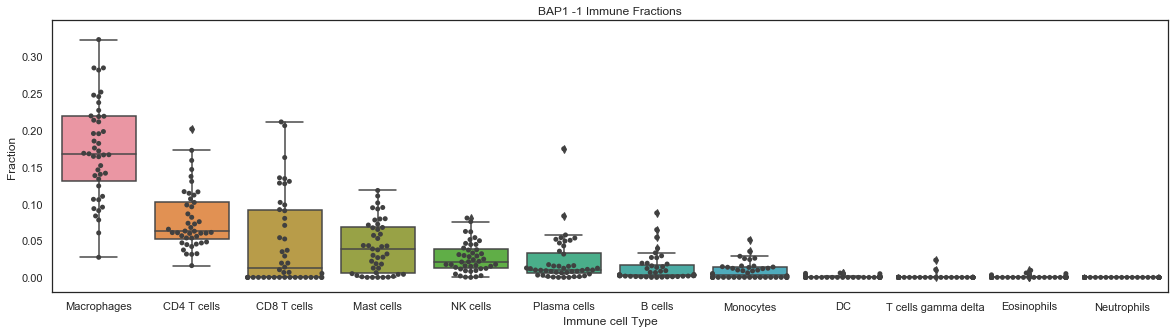

In [108]:
temp_df = pd.DataFrame(data=y[1])
temp_df.columns=immune_fractions_df.columns
temp_df= temp_df.T.assign(m=temp_df.mean(axis=0)).sort_values('m',ascending=False).drop('m', axis=1).T
plt.figure(figsize=(20,5))
sns.swarmplot( data=temp_df,color=".25")
sns.boxplot(data=temp_df)
plt.title("BAP1 -1 Immune Fractions")
plt.xlabel("Immune cell Type")
plt.ylabel("Fraction")

In [109]:
for i in immune_fractions_df.columns:
    print(i, mannwhitneyu(immune_fractions_df.loc[bap_ids[0],i],immune_fractions_df.loc[bap_ids[1],i]))

B cells MannwhitneyuResult(statistic=456.0, pvalue=0.0005880102093911836)
CD4 T cells MannwhitneyuResult(statistic=745.0, pvalue=0.3264631652854366)
CD8 T cells MannwhitneyuResult(statistic=632.0, pvalue=0.05421136930824171)
DC MannwhitneyuResult(statistic=641.0, pvalue=0.04543268254395655)
Eosinophils MannwhitneyuResult(statistic=761.5, pvalue=0.345750648027103)
Macrophages MannwhitneyuResult(statistic=768.0, pvalue=0.4101076574297693)
Mast cells MannwhitneyuResult(statistic=723.0, pvalue=0.2538126526667336)
Monocytes MannwhitneyuResult(statistic=521.0, pvalue=0.003818424348530722)
NK cells MannwhitneyuResult(statistic=773.0, pvalue=0.4290029500048165)


ValueError: All numbers are identical in mannwhitneyu

In [ ]:
for i in immune_fractions_df.columns:
    print(i, stats.pearsonr(gene_expression.loc[bap_ids[0],"BAP1"],immune_fractions_df.loc[bap_ids[0],i]))

In [ ]:
bap1_dfs = [pd.DataFrame(gene_expression.loc[bap_ids[i]]) for i in range(2)]
bap1_dfs[0] = td.variance_threshold_selector(bap1_dfs[0].T, threshold=0.02).T
bap1_dfs[1] = td.variance_threshold_selector(bap1_dfs[1].T, threshold=0.02).T
bap1_dfs[0].shape,bap1_dfs[1].shape
#most_variant = td.variance_threshold_selector(gene_expression.loc[immune_ids[2]].T, threshold=0.03).T
#most_variant.assign(m=most_variant.var(axis=1)).sort_values('m').drop('m', axis=1)

In [ ]:
l = []
for g in bap1_dfs[1]:
    for i in immune_fractions_df.columns:
        r,p = stats.pearsonr(gene_expression.loc[:,g],immune_fractions_df.loc[:,i])
        if p <.05:
            l.append((i, g, r,p))
            #print(i, g, r,p)
l = sorted(l, key=lambda g: g[3], reverse=False)

In [ ]:
print(l[:10])

In [110]:
len(l)

7

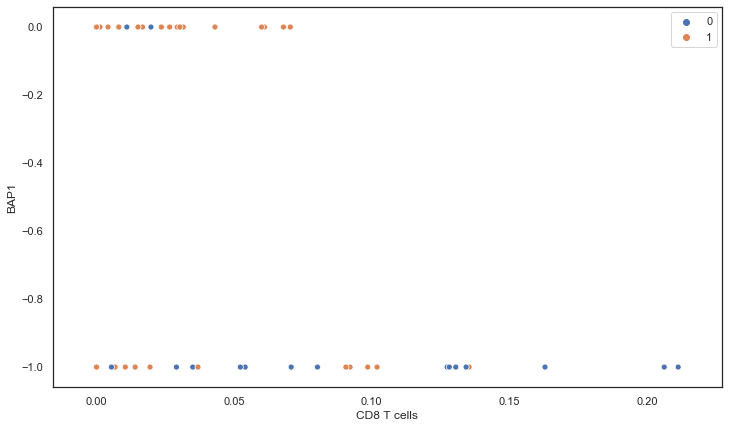

In [111]:
sns.scatterplot(immune_fractions_df.loc[:,"CD8 T cells"],presence_df.loc["BAP1",:],hue=[patient_dict[p]["os_status"] for p in list(immune_fractions_df.index)])

In [112]:
live = [immune_fractions_df.loc[p,"CD8 T cells"] for p in list(gene_expression.index) if patient_dict[p]["os_status"] == 1]
ded = [immune_fractions_df.loc[p,"CD8 T cells"] for p in list(gene_expression.index) if patient_dict[p]["os_status"] == 0]
mannwhitneyu(live,ded)

MannwhitneyuResult(statistic=394.0, pvalue=0.0019417266692595256)

In [113]:
neg1 = [(immune_fractions_df.loc[p,"CD8 T cells"],patient_dict[p]["os_status"]) for p in bap_ids[1] if immune_fractions_df.loc[p,"CD8 T cells"] > 0.025]
neg1 = sorted(neg1, key=lambda g: g[0], reverse=True)
sum([1 for i in neg1 if i[1] == 0])/len(neg1),dead_group[1]

(0.6842105263157895, 0.4772727272727273)

In [114]:
print(sum([1 for p in list(patient_dict.keys()) if patient_dict[p]["os_status"] == 0])/80)

0.2875


(0.5544353736333223, 9.419213639287156e-05)


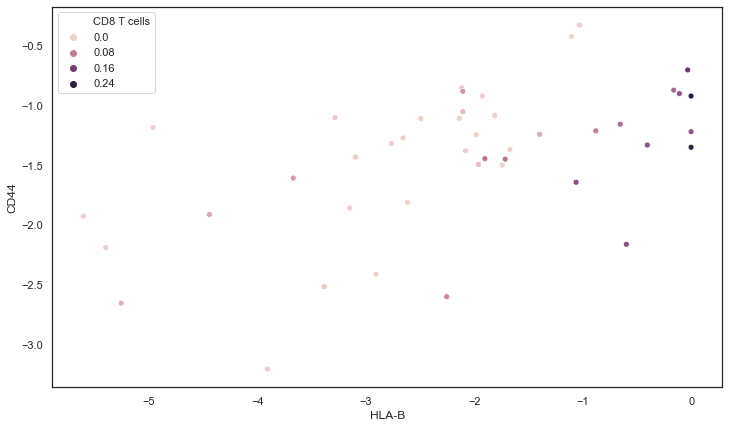

In [115]:
print(stats.pearsonr(np.log(gene_expression.loc[bap_ids[1],"HLA-B"]),np.log(gene_expression.loc[bap_ids[1],"CD44"])))
sns.scatterplot(np.log(gene_expression.loc[bap_ids[1],"HLA-B"]),np.log(gene_expression.loc[bap_ids[1],"CD44"]),hue=immune_fractions_df.loc[bap_ids[1],"CD8 T cells"])

In [116]:
from mpl_toolkits import mplot3d

x = []
for p in bap_ids[1]:
        x.append([gene_expression.loc[p,"HLA-B"],gene_expression.loc[p,"CD44"]])
y = immune_fractions_df.loc[bap_ids[1],"CD8 T cells"]
lin = LinearRegression().fit(x,y)
print(lin.score(x,y))

def f(x,y):
    x=x.reshape((1,-1))
    y=y.reshape((1,-1))
    l = np.asarray([x[0,:],y[0,:]])
    
    return np.asarray(lin.predict(l.reshape(l.shape[1],2))).reshape(60,60)

0.800723318600183


[0.02883528 0.03099015 0.03314501 0.03529988 0.03745475 0.03960961
 0.04176448 0.04391935 0.04607422 0.04822908 0.05038395 0.05253882
 0.05469368 0.05684855 0.05900342 0.06115829 0.06331315 0.06546802
 0.06762289 0.06977776 0.07193262 0.07408749 0.07624236 0.07839722
 0.08055209 0.08270696 0.08486183 0.08701669 0.08917156 0.09132643
 0.02883528 0.03099015 0.03314501 0.03529988 0.03745475 0.03960961
 0.04176448 0.04391935 0.04607422 0.04822908 0.05038395 0.05253882
 0.05469368 0.05684855 0.05900342 0.06115829 0.06331315 0.06546802
 0.06762289 0.06977776 0.07193262 0.07408749 0.07624236 0.07839722
 0.08055209 0.08270696 0.08486183 0.08701669 0.08917156 0.09132643]


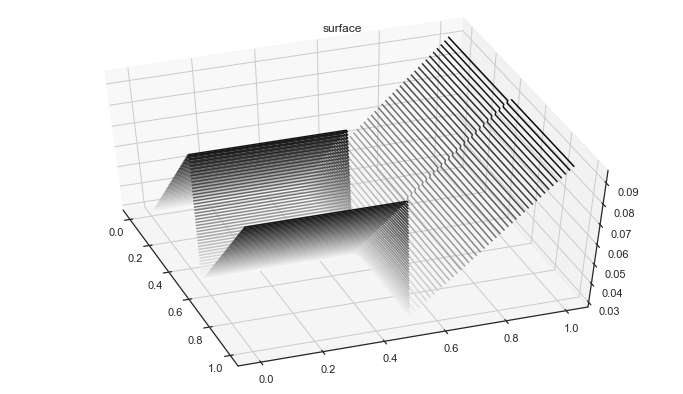

In [117]:
fig = plt.figure()
ax = plt.axes(projection='3d')
x = np.linspace(0, 1, 60)
y = np.linspace(0, 1, 60)

X, Y = np.meshgrid(x, y)
Z = f(X,Y)
print(Z[0])
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, f(X,Y), 50, cmap='binary')
ax.view_init(50, -20)
ax.set_title('surface');

In [118]:
corr_list = []
y = immune_fractions_df.loc[bap_ids[1],"CD8 T cells"]
for g in most_variant[:100]:
    x= []
    for p in bap_ids[1]:
        x.append([gene_expression.loc[p,"HLA-B"],gene_expression.loc[p,g]])
    lin = LinearRegression().fit(x,y)
    corr_list.append((g,lin.score(x,y)))
corr_list=sorted(corr_list, key=lambda g: g[1], reverse=True)
print(corr_list)

[('B2M', 0.7778511658531234), ('PABPC1', 0.7765262648542073), ('HLA-A', 0.7618626665396016), ('GAPDH', 0.7504305202808377), ('CD74', 0.7501874592638642), ('SILV', 0.7432710147778961), ('RPL8', 0.7423743007036661), ('EEF2', 0.7405844402483481), ('VIM', 0.7396991751578134), ('TYRP1', 0.7385217334871668), ('RPS18', 0.7327639993130334), ('HLA-C', 0.7323055777387819), ('ADAM6', 0.7309665373382751), ('RPL13', 0.7307537050383897), ('HLA-B', 0.7307132409072168)]


### EXPRESSION GROUP ANALYSIS

0 1 MannwhitneyuResult(statistic=501.0, pvalue=0.28338102807929477)
0 2 MannwhitneyuResult(statistic=135.0, pvalue=0.008456152480676354)
1 2 MannwhitneyuResult(statistic=109.0, pvalue=0.0021658582058942167)


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1324: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1328: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


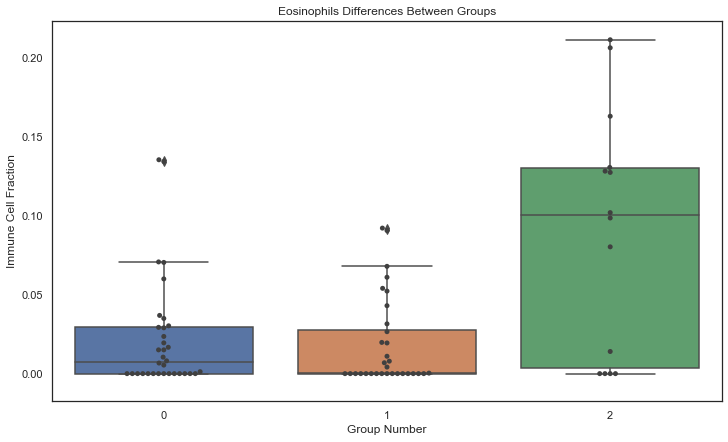

In [119]:
y= [[immune_fractions_df.loc[p,"CD8 T cells"] for p in grouped_ids[i]] for i in range(3)]
#y = [list(immune_fractions_df.loc[immune_ids[i],"Eosinophils"].values) for i in range(4)]
temp_df = pd.DataFrame(data=y)
sns.swarmplot( data=temp_df.T,color=".25")
sns.boxplot(data=temp_df.T)
plt.title("Eosinophils Differences Between Groups")
plt.xlabel("Group Number")
plt.ylabel("Immune Cell Fraction")
for c in combinations(range(3),2):
    print(c[0],c[1],mannwhitneyu([immune_fractions_df.loc[p,"CD8 T cells"] for p in grouped_ids[c[0]]],[immune_fractions_df.loc[p,"CD8 T cells"] for p in grouped_ids[c[1]]]))

In [120]:
living_group= [sum([1 for p in grouped_ids[i] if patient_dict[p]['os_status'] == 1])/len(grouped_ids[i]) for  i in range(3)]
dead_group = [sum([1 for p in grouped_ids[i] if patient_dict[p]['os_status'] == 0])/len(grouped_ids[i]) for  i in range(3)]
v = [living_group,dead_group]

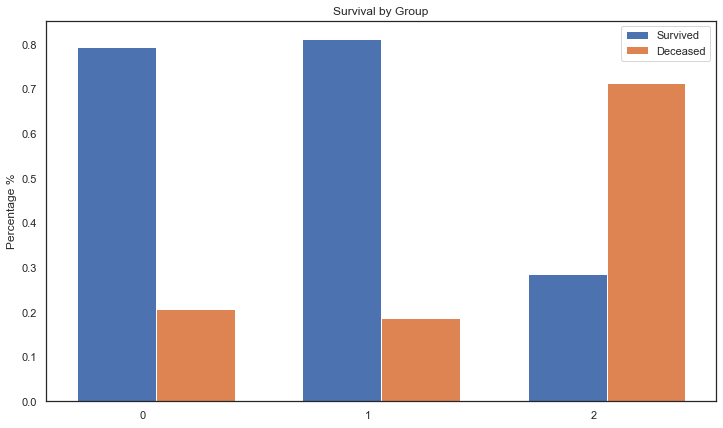

In [121]:
N = 3
ind = np.arange(N) 
width = 0.35       
plt.bar(ind, v[0], width, label='Survived')
plt.bar(ind + width, v[1], width,
    label='Deceased')

plt.ylabel('Percentage %')
plt.title('Survival by Group')

plt.xticks(ind + width / 3, ('0', '1','2'))
plt.legend(loc='best')
plt.show()

In [122]:
for c in combinations(range(3),2):
    s1 = sum([1 for p in grouped_ids[c[0]] if patient_dict[p]['os_status'] == 1])
    s2 = sum([1 for p in grouped_ids[c[1]] if patient_dict[p]['os_status'] == 1])
    print(c[0],c[1],proportions_ztest([s1,s2],[len(grouped_ids[c[0]]),len(grouped_ids[c[1]])]))

0 1 (-0.18766267595171934, 0.8511410906488908)
0 2 (3.347550988306732, 0.0008152898835004991)
1 2 (3.451686095919197, 0.0005570954353934279)


In [123]:
print([sum([1 for p in grouped_ids[i] if patient_dict[p]["BAP1_mutation"] == -1])/len(grouped_ids[i]) for i in range(3)])
print([sum([1 for p in grouped_ids[i] if patient_dict[p]["BAP1_mutation"] == -1]) for i in range(3)])

[0.47058823529411764, 0.4375, 1.0]
[16, 14, 14]


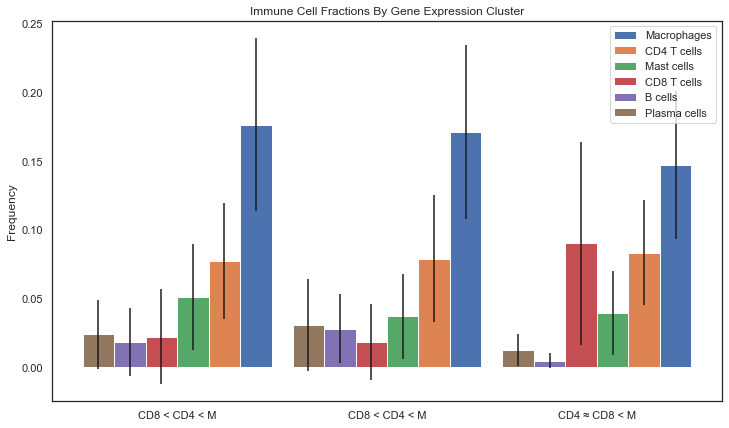

In [124]:
labels = ['CD8 < CD4 < M','CD8 < CD4 < M','CD4 ≈ CD8 < M']
cells = ["Macrophages","CD4 T cells",'Mast cells',"CD8 T cells","B cells",'Plasma cells']
all_means = [[np.mean(immune_fractions_df.loc[grouped_ids[i], c]) for i in range(3)] for c in cells]
all_errors = [[np.std(immune_fractions_df.loc[grouped_ids[i], c]) for i in range(3)] for c in cells]

x = np.arange(len(labels))  # the label locations
width = 0.9  # the width of the bars

fig, ax = plt.subplots()
for i in range(len(cells)):
    ax.bar(x - ((i)-(len(cells)-1)/2)*width/len(cells), all_means[i], width/len(cells), label=cells[i],yerr=all_errors[i])


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency')
ax.set_title('Immune Cell Fractions By Gene Expression Cluster')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

### IMMUNE GROUP ANALYSIS

In [125]:
living_group= [sum([1 for p in immune_ids[i] if patient_dict[p]['os_status'] == 1])/len(immune_ids[i]) for  i in range(4)]
dead_group = [sum([1 for p in immune_ids[i] if patient_dict[p]['os_status'] == 0])/len(immune_ids[i]) for  i in range(4)]
v = [living_group,dead_group]

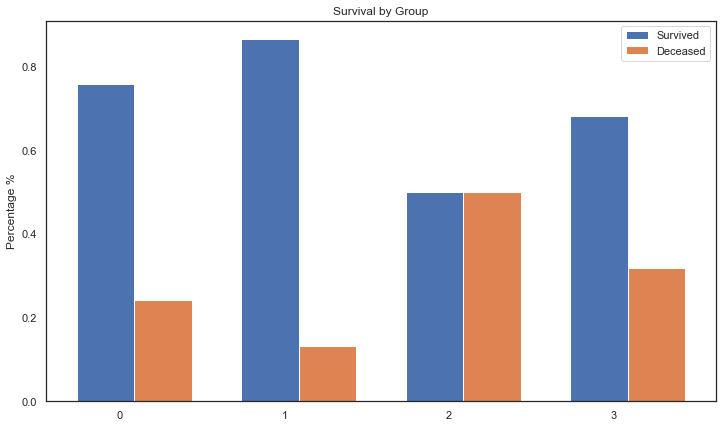

In [126]:
N = 4
ind = np.arange(N) 
width = 0.35       
plt.bar(ind, v[0], width, label='Survived')
plt.bar(ind + width, v[1], width,
    label='Deceased')

plt.ylabel('Percentage %')
plt.title('Survival by Group')

plt.xticks(ind + width / 4, ('0', '1','2','3'))
plt.legend(loc='best')
plt.show()

In [127]:
for c in combinations(range(4),2):
    s1 = sum([1 for p in immune_ids[c[0]] if patient_dict[p]['os_status'] == 1])
    s2 = sum([1 for p in immune_ids[c[1]] if patient_dict[p]['os_status'] == 1])
    print(c[0],c[1],proportions_ztest([s1,s2],[len(immune_ids[c[0]]),len(immune_ids[c[1]])]))

0 1 (-0.8422175574980619, 0.3996661878108978)
0 2 (1.6958892735263793, 0.08990685141856983)
0 3 (0.6087037101308842, 0.542720847386791)
1 2 (2.1327690225862956, 0.03294367859717287)
1 3 (1.286688610568844, 0.19820284442879277)
2 3 (-1.0909090909090906, 0.27531288652196273)


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1324: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1328: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


0 1 MannwhitneyuResult(statistic=206.0, pvalue=0.3926752413177772)
0 2 MannwhitneyuResult(statistic=184.0, pvalue=0.3157976150443349)
0 3 MannwhitneyuResult(statistic=306.0, pvalue=0.4060442731087481)
1 2 MannwhitneyuResult(statistic=93.0, pvalue=0.3078685290201285)
1 3 MannwhitneyuResult(statistic=165.0, pvalue=0.4938297237423794)
2 3 MannwhitneyuResult(statistic=138.0, pvalue=0.3074910460228458)


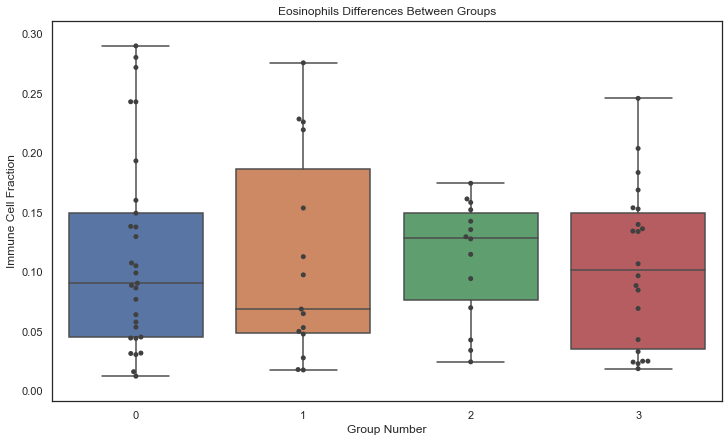

In [172]:
y= [list(gene_expression.loc[immune_ids[i],"RPL5"]) for i in range(4)]
#y = [list(immune_fractions_df.loc[immune_ids[i],"Eosinophils"].values) for i in range(4)]
temp_df = pd.DataFrame(data=y)
sns.swarmplot( data=temp_df.T,color=".25")
sns.boxplot(data=temp_df.T)
plt.title("Eosinophils Differences Between Groups")
plt.xlabel("Group Number")
plt.ylabel("Immune Cell Fraction")
for c in combinations(range(4),2):
    print(c[0],c[1],mannwhitneyu(gene_expression.loc[immune_ids[c[0]],"RPL5"],gene_expression.loc[immune_ids[c[1]],"RPL5"]))

0 1 MannwhitneyuResult(statistic=202.0, pvalue=5.9538214628363195e-09)


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1324: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1328: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


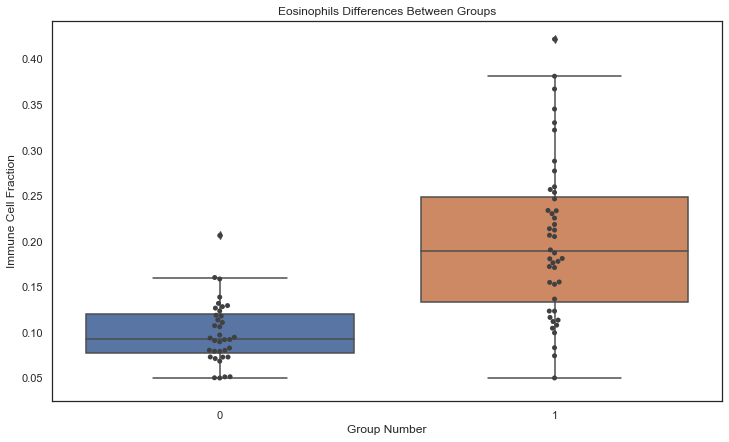

In [179]:
y= [list(gene_expression.loc[bap_ids[i],"FTH1"]) for i in range(2)]
#y = [list(immune_fractions_df.loc[immune_ids[i],"Eosinophils"].values) for i in range(4)]
temp_df = pd.DataFrame(data=y)
sns.swarmplot( data=temp_df.T,color=".25")
sns.boxplot(data=temp_df.T)
plt.title("Eosinophils Differences Between Groups")
plt.xlabel("Group Number")
plt.ylabel("Immune Cell Fraction")
for c in combinations(range(2),2):
    print(c[0],c[1],mannwhitneyu(gene_expression.loc[bap_ids[c[0]],"FTH1"],gene_expression.loc[bap_ids[c[1]],"FTH1"]))

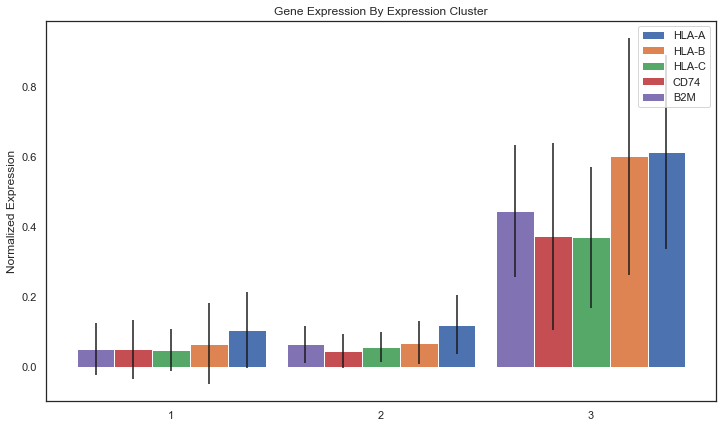

In [130]:
labels = ['1','2','3']
cells = ["HLA-A","HLA-B",'HLA-C',"CD74","B2M"]
all_means = [[np.mean(gene_expression.loc[grouped_ids[i], c]) for i in range(3)] for c in cells]
all_errors = [[np.std(gene_expression.loc[grouped_ids[i], c]) for i in range(3)] for c in cells]

x = np.arange(len(labels))  # the label locations
width = 0.9  # the width of the bars

fig, ax = plt.subplots()
for i in range(len(cells)):
    ax.bar(x - ((i)-(len(cells)-1)/2)*width/len(cells), all_means[i], width/len(cells), label=cells[i],yerr=all_errors[i])


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Normalized Expression')
ax.set_title('Gene Expression By Expression Cluster')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

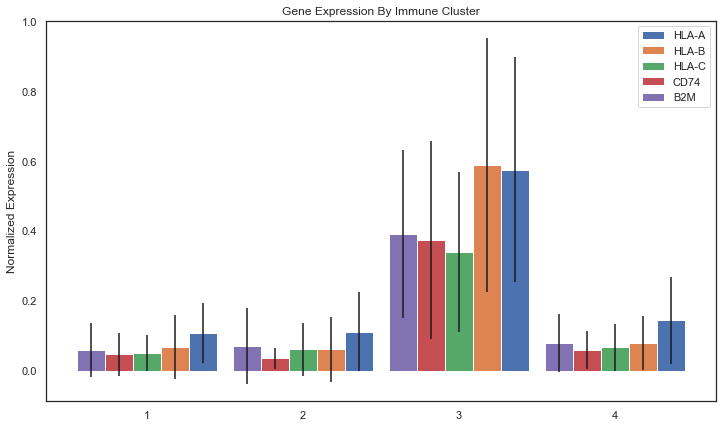

In [131]:
labels = ['1','2','3','4']
cells = ["HLA-A","HLA-B",'HLA-C',"CD74","B2M"]
all_means = [[np.mean(gene_expression.loc[immune_ids[i], c]) for i in range(4)] for c in cells]
all_errors = [[np.std(gene_expression.loc[immune_ids[i], c]) for i in range(4)] for c in cells]

x = np.arange(len(labels))  # the label locations
width = 0.9  # the width of the bars

fig, ax = plt.subplots()
for i in range(len(cells)):
    ax.bar(x - ((i)-(len(cells)-1)/2)*width/len(cells), all_means[i], width/len(cells), label=cells[i],yerr=all_errors[i])


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Normalized Expression')
ax.set_title('Gene Expression By Immune Cluster')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

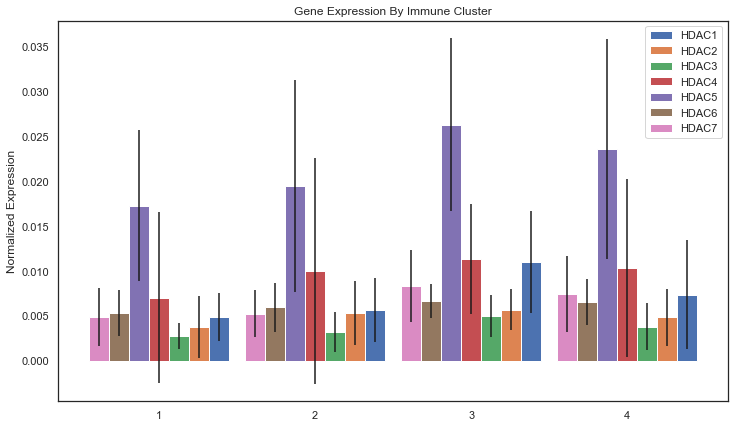

In [132]:
labels = ['1','2','3','4']
cells = ["HDAC1","HDAC2","HDAC3","HDAC4","HDAC5","HDAC6","HDAC7"]
all_means = [[np.mean(gene_expression.loc[immune_ids[i], c]) for i in range(4)] for c in cells]
all_errors = [[np.std(gene_expression.loc[immune_ids[i], c]) for i in range(4)] for c in cells]

x = np.arange(len(labels))  # the label locations
width = 0.9  # the width of the bars

fig, ax = plt.subplots()
for i in range(len(cells)):
    ax.bar(x - ((i)-(len(cells)-1)/2)*width/len(cells), all_means[i], width/len(cells), label=cells[i],yerr=all_errors[i])


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Normalized Expression')
ax.set_title('Gene Expression By Immune Cluster')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

HDAC1 MannwhitneyuResult(statistic=407.0, pvalue=0.00010020775928581038)
HDAC2 MannwhitneyuResult(statistic=500.0, pvalue=0.0024079936669939043)
HDAC3 MannwhitneyuResult(statistic=309.0, pvalue=1.5337451231736643e-06)
HDAC4 MannwhitneyuResult(statistic=151.0, pvalue=2.9279141558171836e-10)
HDAC5 MannwhitneyuResult(statistic=184.0, pvalue=2.112674445066609e-09)
HDAC6 MannwhitneyuResult(statistic=438.0, pvalue=0.00031461483353496567)
HDAC7 MannwhitneyuResult(statistic=241.0, pvalue=5.0789867681909725e-08)
HDAC8 MannwhitneyuResult(statistic=325.0, pvalue=3.2183481983239523e-06)
HDAC9 MannwhitneyuResult(statistic=589.0, pvalue=0.025093093384487664)


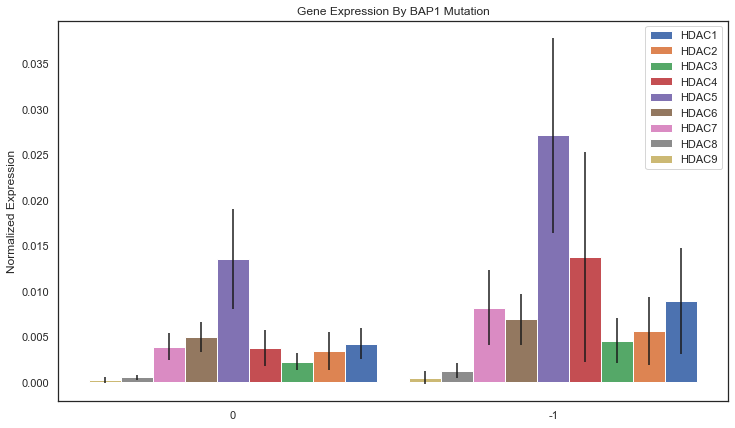

In [133]:
labels = ['0','-1']
cells = ["HDAC1","HDAC2","HDAC3","HDAC4","HDAC5","HDAC6","HDAC7","HDAC8","HDAC9"]
all_means = [[np.mean(gene_expression.loc[bap_ids[i], c]) for i in range(2)] for c in cells]
all_errors = [[np.std(gene_expression.loc[bap_ids[i], c]) for i in range(2)] for c in cells]

x = np.arange(len(labels))  # the label locations
width = 0.9  # the width of the bars

fig, ax = plt.subplots()
for i in range(len(cells)):
    ax.bar(x - ((i)-(len(cells)-1)/2)*width/len(cells), all_means[i], width/len(cells), label=cells[i],yerr=all_errors[i])


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Normalized Expression')
ax.set_title('Gene Expression By BAP1 Mutation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
for c in cells:
    print(c,mannwhitneyu(gene_expression.loc[bap_ids[0], c],gene_expression.loc[bap_ids[1], c]))

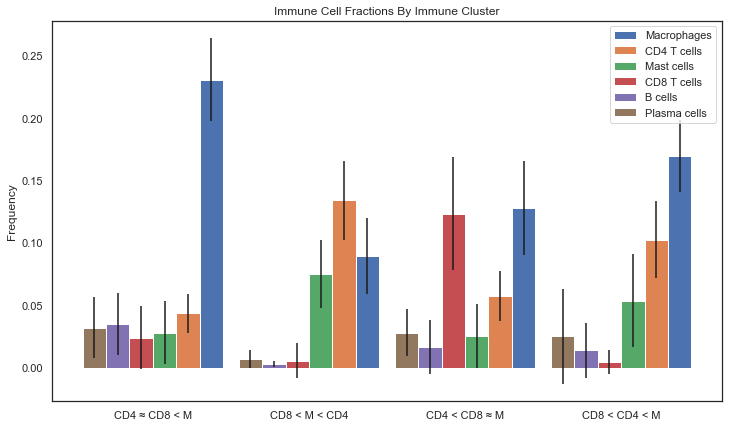

In [134]:
labels = ['CD4 ≈ CD8 < M','CD8 < M < CD4','CD4 < CD8 ≈ M','CD8 < CD4 < M']
cells = ["Macrophages","CD4 T cells",'Mast cells',"CD8 T cells","B cells",'Plasma cells']
all_means = [[np.mean(immune_fractions_df.loc[immune_ids[i], c]) for i in range(4)] for c in cells]
all_errors = [[np.std(immune_fractions_df.loc[immune_ids[i], c]) for i in range(4)] for c in cells]

x = np.arange(len(labels))  # the label locations
width = 0.9  # the width of the bars

fig, ax = plt.subplots()
for i in range(len(cells)):
    ax.bar(x - ((i)-(len(cells)-1)/2)*width/len(cells), all_means[i], width/len(cells), label=cells[i],yerr=all_errors[i])


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency')
ax.set_title('Immune Cell Fractions By Immune Cluster')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

In [135]:
mannwhitneyu([1 if patient_dict[p]["os_status"] == 1 else 0 for p in immune_ids[3]],[1 if patient_dict[p]["os_status"] == 1 else 0 for p in immune_ids[2]])

MannwhitneyuResult(statistic=126.0, pvalue=0.1453829761575518)

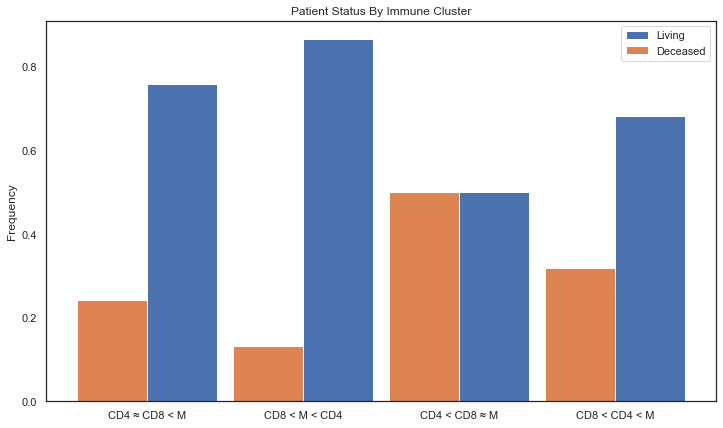

In [136]:
labels = ['CD4 ≈ CD8 < M','CD8 < M < CD4','CD4 < CD8 ≈ M','CD8 < CD4 < M']
cells = ["Living","Deceased"]
living_means = [[np.mean([1 if patient_dict[p]["os_status"] == 1 else 0 for p in immune_ids[i]]) if c == "Living" \
                 else 1-np.mean([1 if patient_dict[p]["os_status"] == 1 else 0 for p in immune_ids[i]]) for i in range(4)] for c in cells]

x = np.arange(len(labels))  # the label locations
width = 0.9  # the width of the bars

fig, ax = plt.subplots()
for i in range(len(cells)):
    ax.bar(x - ((i)-(len(cells)-1)/2)*width/len(cells), living_means[i], width/len(cells), label=cells[i])


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency')
ax.set_title('Patient Status By Immune Cluster')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

### ANALYSIS OVER ALL PATIENTS

In [137]:
phenotypes = ["DSS_time","age","tumor_size","os_status","weight","bmi"]
for phen in phenotypes:
    #for opt in [0,1,2]:
   #     print(opt, " Patients:")
    for i in range(len(immune_fractions_df.columns)):
        x = []
        y = []
        for p in list(patient_dict.keys()):
            if not np.isnan(patient_dict[p][phen]):
                x.append(patient_dict[p]['immune_fractions'][i])
                y.append(patient_dict[p][phen])
        x = np.asarray(x)
        r, p = stats.pointbiserialr(x,y)
        if p < .05:
            print(immune_fractions_df.columns[i],'vs',phen , " :", r, p, i)

B cells vs tumor_size  : -0.29962597188380985 0.008551145070532992 0
CD8 T cells vs os_status  : -0.4051956124886904 0.00019270033567450037 2
Monocytes vs os_status  : 0.2807915634796685 0.01163825629922088 7


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


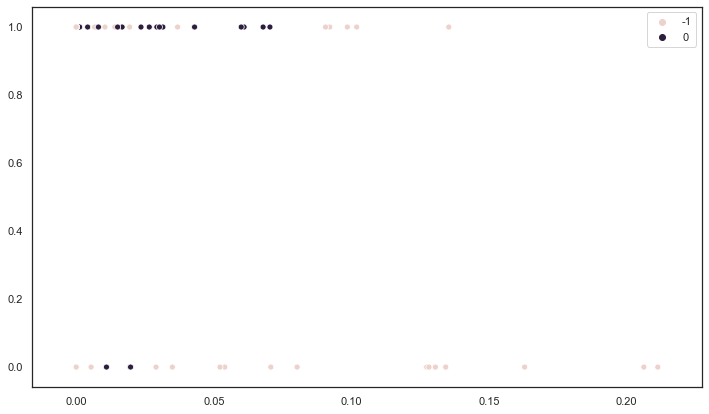

In [138]:
sns.scatterplot([patient_dict[p]['immune_fractions'][2] for p in list(gene_expression.index)],[patient_dict[p]['os_status']for p in list(gene_expression.index)],hue=[patient_dict[p]['BAP1_mutation']for p in list(gene_expression.index)])

In [139]:
higher_cd8 = [p for p in list(immune_fractions_df.index) if immune_fractions_df.loc[p, "CD8 T cells"] < .03253]

In [140]:
np.mean([immune_fractions_df.loc[p, "CD8 T cells"] for p in list(immune_fractions_df.index)])

0.03253848875513572

In [141]:
print(sum([1 for p in higher_cd8 if patient_dict[p]['os_status'] == 0])/len(higher_cd8))

0.19298245614035087


In [142]:
Counter([presence_df.loc["CD74",p] for p in list(presence_df.columns)])

Counter({0: 73, -2: 1, 1: 3, -1: 3})

In [143]:
Counter([presence_df.loc["HLA-C",p] for p in list(presence_df.columns)])
hla_groups = [[],[],[]]
for p in list(gene_expression.index):
    if presence_df.loc["HLA-B",p] == 0:
        hla_groups[0].append(p)
    elif presence_df.loc["HLA-B",p] == 1:
        hla_groups[1].append(p)
    else: 
        hla_groups[2].append(p)

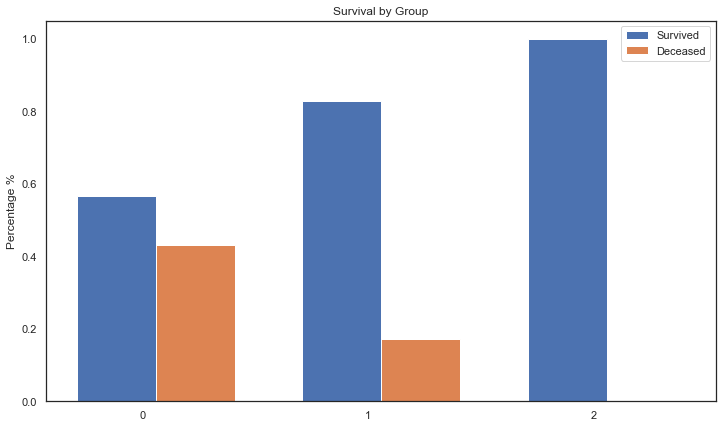

In [144]:
living_group= [sum([1 for p in hla_groups[i] if patient_dict[p]['os_status'] == 1])/len(hla_groups[i]) for  i in range(3)]
dead_group = [sum([1 for p in hla_groups[i] if patient_dict[p]['os_status'] == 0])/len(hla_groups[i]) for  i in range(3)]
v = [living_group,dead_group]
N = 3
ind = np.arange(N) 
width = 0.35       
plt.bar(ind, v[0], width, label='Survived')
plt.bar(ind + width, v[1], width,
    label='Deceased')

plt.ylabel('Percentage %')
plt.title('Survival by Group')

plt.xticks(ind + width / 3, ('0', '1','2'))
plt.legend(loc='best')
plt.show()

In [145]:
for c in combinations(range(3),2):
    s1 = sum([1 for p in hla_groups[c[0]] if patient_dict[p]['os_status'] == 1])
    s2 = sum([1 for p in hla_groups[c[1]] if patient_dict[p]['os_status'] == 1])
    print(c[0],c[1],proportions_ztest([s1,s2],[len(hla_groups[c[0]]),len(hla_groups[c[1]])]))

0 1 (-2.531044349111985, 0.01137234684302324)
0 2 (-1.2109954534386653, 0.22589714720175302)
1 2 (-0.6386384568680359, 0.5230581574745596)


In [146]:
#np.median([immune_fractions_df.loc[p, "CD8 T cells"] for p in list(immune_fractions_df.index)])
cd8_split = np.percentile([immune_fractions_df.loc[p, "CD8 T cells"] for p in list(immune_fractions_df.index)],50)
higher_cd8 = [p for p in list(immune_fractions_df.index) if immune_fractions_df.loc[p, "CD8 T cells"] > cd8_split]
lower_cd8 = [p for p in list(immune_fractions_df.index) if immune_fractions_df.loc[p, "CD8 T cells"] < cd8_split]
bap11_and_hla_high = [p for p in higher_cd8 if patient_dict[p]['BAP1_mutation'] == -1]
print(sum([1 for p in bap11_and_hla_high if patient_dict[p]['os_status'] == 0])/len(bap11_and_hla_high),len(bap11_and_hla_high))
bap11_and_hla_low = [p for p in lower_cd8 if patient_dict[p]['BAP1_mutation'] == -1]
print(sum([1 for p in bap11_and_hla_low if patient_dict[p]['os_status'] == 0])/len(bap11_and_hla_low),len(bap11_and_hla_low))
bap10_and_hla_high = [p for p in higher_cd8 if patient_dict[p]['BAP1_mutation'] == 0]
print(sum([1 for p in bap10_and_hla_high if patient_dict[p]['os_status'] == 0])/len(bap10_and_hla_high),len(bap10_and_hla_high))
bap10_and_hla_low = [p for p in lower_cd8 if patient_dict[p]['BAP1_mutation'] == 0]
print(sum([1 for p in bap10_and_hla_low if patient_dict[p]['os_status'] == 0])/len(bap10_and_hla_low),len(bap10_and_hla_low))

0.6086956521739131 23
0.3333333333333333 21
0.11764705882352941 17
0.0 19


In [147]:
bap_hla = [bap11_and_hla_high,bap11_and_hla_low,bap10_and_hla_high,bap10_and_hla_low]

for c in combinations(range(4),2):
    s1 = sum([1 for p in bap_hla[c[0]] if patient_dict[p]['os_status'] == 1])
    s2 = sum([1 for p in bap_hla[c[1]] if patient_dict[p]['os_status'] == 1])
    print(c[0],c[1],proportions_ztest([s1,s2],[len(bap_hla[c[0]]),len(bap_hla[c[1]])]))

0 1 (-1.8265469859928285, 0.06776791052625826)
0 2 (-3.1338429869742472, 0.0017253314966973866)
0 3 (-4.165072158673427, 3.112541043867668e-05)
1 2 (-1.554992009706697, 0.11994797232379519)
1 3 (-2.770698048645445, 0.005593627176535223)
2 3 (-1.5384349212496495, 0.1239423092686433)


In [148]:
print(mannwhitneyu(immune_fractions_df.loc[bap11_and_hla_low,"CD8 T cells"],immune_fractions_df.loc[bap10_and_hla_low,"CD8 T cells"]))
print(mannwhitneyu(immune_fractions_df.loc[bap11_and_hla_high,"CD8 T cells"],immune_fractions_df.loc[bap10_and_hla_high,"CD8 T cells"]))

MannwhitneyuResult(statistic=198.0, pvalue=0.4826148489812382)
MannwhitneyuResult(statistic=77.0, pvalue=0.0006223432400912949)


In [149]:
stats.pearsonr(gene_expression.loc[:,"BAP1"], gene_expression.loc[:,"HDAC1"])

(0.02359778393886544, 0.8354069555634391)

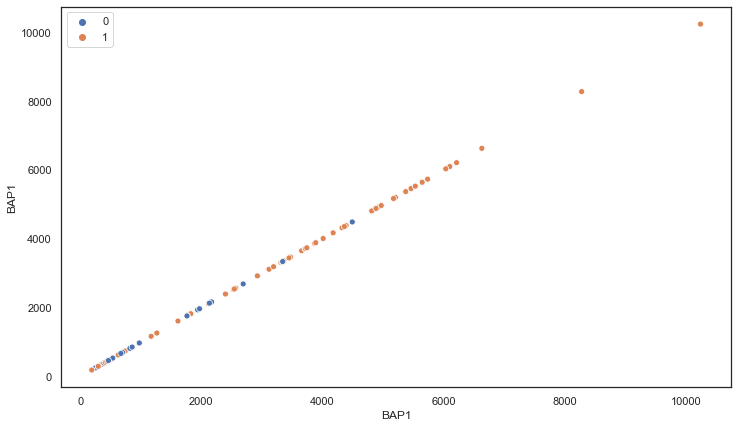

In [163]:
sns.scatterplot(weird_gene_expression.loc[:,"BAP1"],weird_gene_expression.loc[:,"BAP1"], hue=[patient_dict[p]['os_status'] for p in list(gene_expression.index)])

In [151]:
lin = LinearRegression().fit(gene_expression.loc[bap_ids[1],"APOL6"].values.reshape(-1,1),immune_fractions_df.loc[bap_ids[1],"CD8 T cells"].values.reshape(-1,1))
lin.score(gene_expression.loc[bap_ids[1],"APOL6"].values.reshape(-1,1),immune_fractions_df.loc[bap_ids[1],"CD8 T cells"].values.reshape(-1,1))

0.6044058215048235

In [152]:
[print(len(immune_ids[i])) for i in range(4)]

29
15
14
22


[None, None, None, None]

In [153]:
from causality.inference.search import IC
from causality.inference.independence_tests import RobustRegressionTest

In [154]:
# load the data into a dataframe:
p = list(gene_expression.index)
causal_dict = {}
causal_dict['HLA-B'] = gene_expression.loc[p,"HLA-B"]
causal_dict['HLA-A'] = gene_expression.loc[p,"HLA-A"]
causal_dict['HDAC1'] = gene_expression.loc[p,"HDAC1"]
causal_dict['CD74'] = gene_expression.loc[p,"CD74"]
causal_dict['B2M'] = gene_expression.loc[p,"B2M"]
causal_dict['BAP1'] = gene_expression.loc[p,"BAP1"]
causal_dict['CD8 T cells'] = immune_fractions_df.loc[p,"CD8 T cells"]
#causal_dict['BAP1 Mutation'] = [0 if patient_dict[i]["BAP1_mutation"] == 0 else 1 for i in p]
causal_dict['Mortality Rate'] = [0 if patient_dict[i]["os_status"] == 0 else 1 for i in p]


X = pd.DataFrame(causal_dict)

# define the variable types: 'c' is 'continuous'. The variables defined here
# are the ones the search is performed over -- NOT all the variables defined
# in the data frame.
variable_types = {'HLA-B' : 'c', 'HLA-A' : 'c', 'HDAC1' : 'c', 'CD74' : 'c', 'B2M' : 'c', 'CD8 T cells' : 'c', 'BAP1' : 'c', 'Mortality Rate' : 'd'}

# run the search
ic_algorithm = IC(RobustRegressionTest)
graph = ic_algorithm.search(X, variable_types)

In [155]:
graph.edges()

EdgeView([('HLA-B', 'HLA-A'), ('HLA-B', 'CD74'), ('HLA-B', 'B2M'), ('HLA-B', 'CD8 T cells'), ('HLA-A', 'HDAC1'), ('HDAC1', 'BAP1'), ('CD74', 'CD8 T cells'), ('BAP1', 'Mortality Rate')])

In [156]:
import scipy.spatial as spatial

def heat_plot(X,Y,Z,radius, num_points):
    X= X/X.max()
    Y=Y/Y.max()
    points = np.asarray([(X[i],Y[i]) for i in range(len(X))])
    print(len(points))
    points_tree = spatial.cKDTree(points)
    x = np.linspace(0,1,num_points)
    y = np.linspace(0,1,num_points)
    z = np.zeros((len(x),len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            in_range = points_tree.query_ball_point([x[i],y[j]],radius)
            z[i][j] = np.mean(Z[in_range])
    temp_df = pd.DataFrame(data=z,columns = x,index=y)
    ax = sns.heatmap(temp_df)
    ax.invert_yaxis()
    return z

80


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


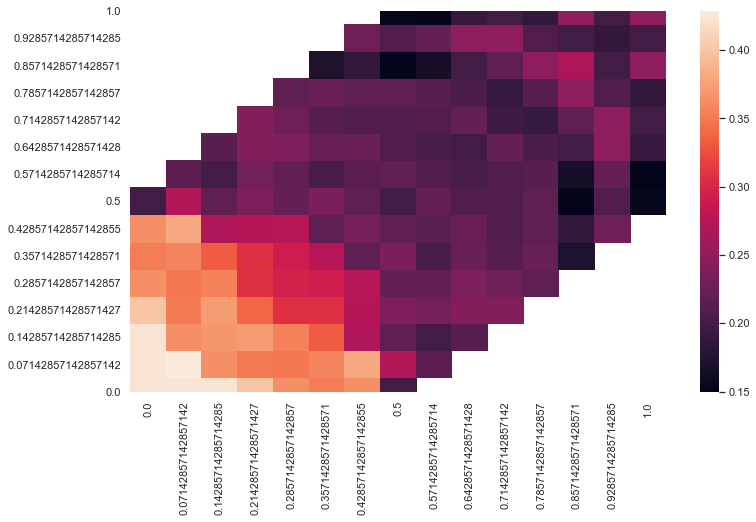

In [157]:
z = heat_plot(gene_expression.loc[:,"BAP1"],gene_expression.loc[:,"BAP1"],np.asarray([1 if patient_dict[p]['os_status'] == 0 else 0 for p in list(gene_expression.index)]),.4,15)

80


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


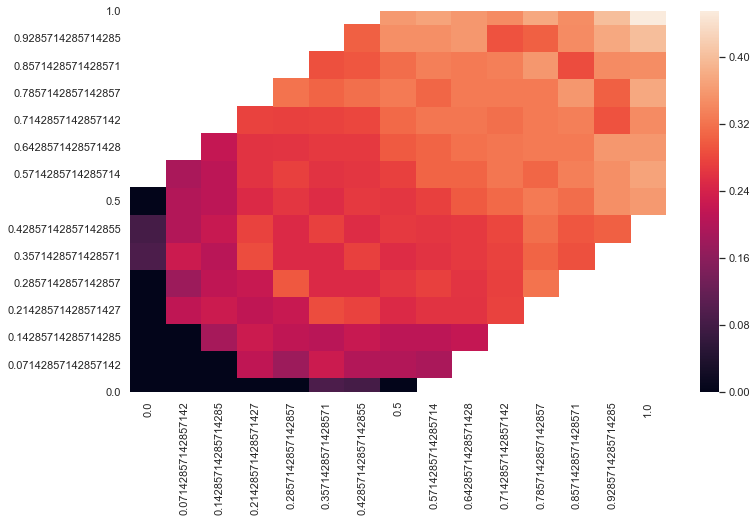

In [180]:
z = heat_plot(weird_gene_expression.loc[:,"FTH1"],weird_gene_expression.loc[:,"FTH1"],np.asarray([1 if patient_dict[p]['os_status'] == 0 else 0 for p in list(gene_expression.index)]),.4,15)

80


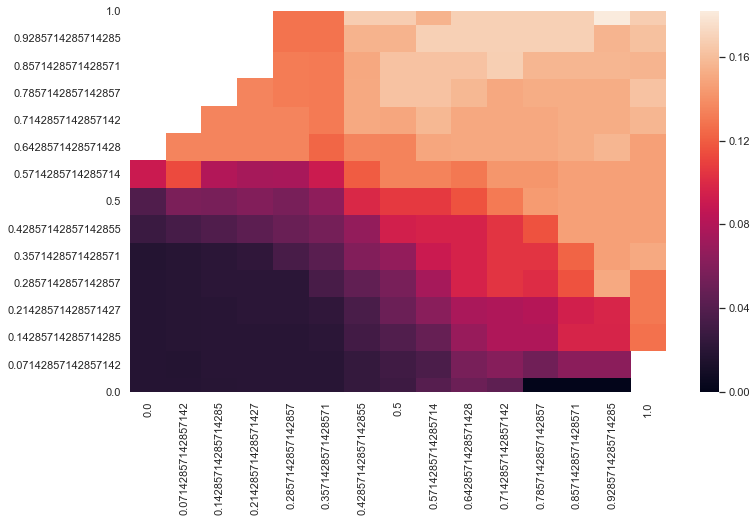

In [158]:
z = heat_plot(gene_expression.loc[:,"CD74"],gene_expression.loc[:,"B2M"],immune_fractions_df.loc[:,"CD8 T cells"],.4,15)

80


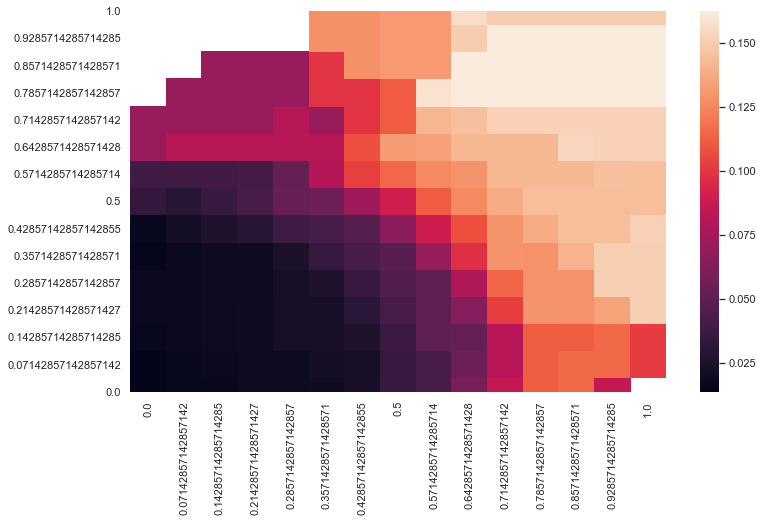

In [165]:
z = heat_plot(weird_gene_expression.loc[:,"CD74"],weird_gene_expression.loc[:,"B2M"],immune_fractions_df.loc[:,"CD8 T cells"],.4,15)